<a name="outline"></a>
# Predicting Visual Perception in Mice with Neuropixel Data

>   The goal of this project is to predict the visual stimulus presented to mice based on the firing network of the synapses between their neurons. We utilize data from the Ecephys Project, which employs Neuropixel technology to record large-scale neural activity. The neural activity, called action potentials, is the a electrical signal generated by the movement of charged ions across the membrane of a neuron. Each unique action potential can also be referred to as a unit. The following analysis includes creating a binned binary spike train dataset from the spike trains given by the Allen Institute, visualizing useful information, and applying deep learning as well as machine learning techniques for image prediction.

</div>
<img src="pictures/Hyper Parameter Tuning.png" width="500" height="800" alt="Alt text"/>
</div>

*** Setup the environment. ***

In [6]:
# Setup Environment
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import psutil
import time
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVR
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
import torch
import pickle
#from torch_geometric.data import Data
#from torch_geometric.nn import GCNConv, GATConv, GATv2Conv
from torch.nn import Linear
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import concurrent.futures
import warnings
from concurrent.futures import ProcessPoolExecutor
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache


#DOWNLOAD_COMPLETE_DATASET = True

if torch.cuda.is_available():
    print("CUDA GPU is available.")
    device = torch.device('cuda')
else:
    print("CUDA GPU is not available. Using CPU instead.")
    device = torch.device('cpu')
    
print(f"Current GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
print(f"Total RAM: {(psutil.virtual_memory().total / (1024**3)):.2f} GB")
print(f"Available RAM: {(psutil.virtual_memory().available / (1024**3)):.2f} GB")

CUDA GPU is available.
Current GPU device: NVIDIA A100-PCIE-40GB MIG 2g.10gb
Total RAM: 1006.97 GB
Available RAM: 864.61 GB


## ***Index***

<a name="step1"></a>
### 1. Pull, Process, or Load Pre-Processed Data

    Pull data from the Ecephys repository, process it, then save it to a pickle file.
    If the data has already been processed, it will load from a saved directory.

- 1.1) Get non-normalized firing rates.
- 1.2) Get normalized firing rates.

[Go to Step 1](#step1content)

<a name="step2"></a>
### 2. Visualize the Data

    Here we will run visualizations to explore the information relevant to predicting visual perception with the data.

- 2.0) Pull image data from the Allen SDK Package.
- 2.1) All natural scenes presented by their frame number.
- 2.2) Visualize the unique firing pattern of different single units (usually a single neuron).
- 2.3) Raster plot of the spike trains for single units over the course of the natural scene testing.
- 2.4) Sorted correlation matrix between single units.
- 2.5) Grouped heat maps of unit responses by frames.
- 2.6) Average firing rates of units during each frame, in Hertz and by Z scores.

[Go to Step 2](#step2content)

<a name="step3"></a>
### 3. Image Prediction Modeling
    
    The purpose of this section is to...
    1. Employ various machine learning and deep learning techniques to predict the visual stimulus given the data.
    2. Produce directed adjacency matrices using a Spatio-Temporal Graph Neural Network. These adjacency matrices may represent the directed functional connectomics between units, usually single neurons, during each frame.
    3. Visualize the network of single units over time.
    
- 3.0) Create train splits, test splits.
- 3.1) Baseline Model: a random guess with an accuracy of 0.85% (1/118).
- 3.2) Support Vector Machine with Radial Basis Function.
- 3.3) Principal Component Regression.
- 3.4) Multi-Class Regression with L2 Regularizaiton.
- 3.5) Neural Network with one hidden layer.
- 3.6) Neural Network with multiple hidden layers.
- 3.7) Graph Convolution Network(GCN).
- 3.8) Graph Attention Network(GAT).
- 3.9) Long Short-Term Memory(LSTM).
- 3.10) Spatio-Temporal Graph Attention Network(ST-GAT).
- 3.11) Transformer.

[Go to Step 3](#step3content)


## References
[Go to References](#references)

<a name="step1content"></a>
## 1. Pull, Process, or Load Pre-Processed Data
[Go to Outline](#outline)

#### Get non-normalized firing rates.

In [2]:
from data_processors.pull_and_process_data import master_function
warnings.filterwarnings("ignore", message="Ignoring cached namespace")

## 1. Pull and Process Data
mouse_number = 715093703
spike_df = master_function(session_number=mouse_number, output_dir="output", timesteps_per_frame=1)

Using device: cuda
Using device: cuda
Updated version 3!
Initializing workflow...
Loading existing raw datasets...
Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
Total time elapsed: 0.01 seconds


#### Get normalized firing rates.

In [3]:
## 0. Load Pre-Processed Data 
from data_processors.load_processed_data import master_cleaning_and_saving

normalized_firing_rates = master_cleaning_and_saving(session_id = mouse_number, original_pickle_prefix = 'spike_trains_with_stimulus_session', timesteps_per_frame = 3)

Data saved to /proj/STOR/pipiras/Neuropixel/Neuropixels-Pipeline-Refactor/src/output/normalized_firing_rates_715093703_3.pkl
Original data file for session 715093703 has been cleaned and saved.


<a name="step2content"></a>
## 2. Visualize the Data
[Go to Outline](#outline)

Here we visualize different aspects of the data spike train data.

- 2.0) Pull image data from the Allen SDK Package.
- 2.1) All natural scenes presented by their frame number.
- 2.2) Visualize the mean extracellular spike waveform of different single units (putative neurons).
- 2.3) Raster plot of the spike trains for single units over the course of the natural scene testing.
- 2.4) Sorted correlation matrix between single units.
- 2.5) Grouped heat maps of unit responses by frames.
  - 2.5.1) Heat maps of unit responses by all frames.
  - 2.5.2) Heat maps of unit responses by select number of frames.
- 2.6) Average firing rates of units during each frame, in Hertz and by Z scores.
  - 2.6.1) Average firing rates of chosen number of units during each frame, in Hertz.
  - 2.6.2) Average firing rates of all units during each frame, in Hertz.
  - 2.6.3) Average firing rates of all normalized units during each frame, in Hertz.
  - 2.6.4) Average firing rates of chosen normalized units during each frame, in Hertz.


### 2.0) Pull image data from the Allen SDK Package.

*** To set up the environment for visualizations. *** \
1st, run 2.0.1. \
2nd, run 2.0.2 if one hasn't already calculated the average firing rate per frame. If they haven't been calculated, run 2.0.3 to load them in.

#### 2.0.1) Run Cell to set up environment for visualizations.

In [7]:
# Define Carolina blue color (in RGB format)
carolina_blue = (86/255, 160/255, 211/255)

# Set output directory to a new folder called 'output' in the current working directory
output_dir = "/proj/STOR/pipiras/Neuropixel/Neuropixels-Pipeline-Refactor/src/output"

# Create a file path to the manifest.json file within the output directory
manifest_path = os.path.join(output_dir, "manifest.json")

# Create an instance of the EcephysProjectCache class with the manifest file path as argument
cache = EcephysProjectCache(manifest=manifest_path)
# Get session table
session_table = cache.get_session_table()

#Pick session number that already has a .nwb file in /output"
session_number = 715093703

# Pull session.
session = cache.get_session_data(session_number,
                                 isi_violations_maximum = np.inf,
                                 amplitude_cutoff_maximum = np.inf,
                                 presence_ratio_minimum = -np.inf
                                )

# Get spike times.
spike_times = session.spike_times
# Get specific stimulus table.
stimulus_table = session.get_stimulus_table("natural_scenes")

# Display objects within session.
print("Session objects")
print([attr_or_method for attr_or_method in dir(session) if attr_or_method[0] != '_'])

/nas/longleaf/home/dkofma60/.local/lib/python3.11/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/nas/longleaf/home/dkofma60/.local/lib/python3.11/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/nas/longleaf/home/dkofma60/.l

Session objects
['DETAILED_STIMULUS_PARAMETERS', 'LazyProperty', 'age_in_days', 'api', 'channel_structure_intervals', 'channels', 'conditionwise_spike_statistics', 'ecephys_session_id', 'from_nwb_path', 'full_genotype', 'get_current_source_density', 'get_inter_presentation_intervals_for_stimulus', 'get_invalid_times', 'get_lfp', 'get_parameter_values_for_stimulus', 'get_pupil_data', 'get_screen_gaze_data', 'get_stimulus_epochs', 'get_stimulus_parameter_values', 'get_stimulus_table', 'inter_presentation_intervals', 'invalid_times', 'mean_waveforms', 'metadata', 'num_channels', 'num_probes', 'num_stimulus_presentations', 'num_units', 'optogenetic_stimulation_epochs', 'presentationwise_spike_counts', 'presentationwise_spike_times', 'probes', 'rig_equipment_name', 'rig_geometry_data', 'running_speed', 'session_start_time', 'session_type', 'sex', 'specimen_name', 'spike_amplitudes', 'spike_times', 'stimulus_conditions', 'stimulus_names', 'stimulus_presentations', 'structure_acronyms', 'stru

In [7]:
output_dir = "/proj/STOR/pipiras/Neuropixel/Neuropixels-Pipeline-Refactor/src/output"
manifest_path = os.path.join(output_dir, "manifest.json")
cache = EcephysProjectCache(manifest=manifest_path)

# List of session IDs for which you want to pull the information
session_ids = [715093703, 719161530, 721123822, 732592105, 737581020, 739448407, 742951821, 743475441, 744228101, 746083955, 750332458, 750749662, 751348571, 754312389, 754829445, 755434585, 756029989, 757216464, 757970808, 758798717, 759883607, 760345702, 760693773, 761418226, 762120172, 762602078, 763673393, 773418906, 791319847, 797828357, 798911424, 799864342]
sess_tbl = cache.get_session_table()
wanted = sess_tbl.loc[session_ids, ['specimen_id', 'full_genotype', 'age_in_days', 'sex']].reset_index()

# Save the DataFrame to a CSV file
out_csv = '/proj/STOR/pipiras/Neuropixel/Neuropixels-Pipeline-Refactor/src/output/mouse_info.csv'
wanted.to_csv(out_csv, index=False)
print(f"Saved to {out_csv}")

Saved to /proj/STOR/pipiras/Neuropixel/Neuropixels-Pipeline-Refactor/src/output/mouse_info.csv


#### 2.0.2) Calulate the firing rates per frame, average firing rate per image, and average firing rate per second.

Load data.

In [11]:
from data_processors.pull_and_process_data import master_function

session_number = 715093703
timesteps_per_frame = 1
output_dir = "/proj/STOR/pipiras/Neuropixel/Neuropixels-Pipeline-Refactor/src/output"

spike_df = master_function(session_number=session_number,
                           output_dir=output_dir,
                           timesteps_per_frame=timesteps_per_frame,
                           timeout=300)

#drop bins when no image was shown
spikes_per_frame = spike_df[spike_df['frame'] >= 0].reset_index(drop=True)

Using device: cuda
Updated version 3!
Initializing workflow...
Loading existing raw datasets...
Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
Total time elapsed: 0.02 seconds


Calculate average spikes per image (per 250 milisecond exposure window).

In [7]:
neuron_cols = [c for c in spikes_per_frame.columns if c != 'frame']
spikes_per_image = (
    spikes_per_frame
      .groupby('frame', sort=True)[neuron_cols]
      .mean()
      .reset_index()
)
spikes_per_image

frame  950910332  950910326  950910319  950910311  950910345  950910364  \
0      0.0       0.38       0.00       5.40       2.04       0.50       6.44   
1      1.0       0.30       0.00       5.22       1.74       0.48       6.14   
2      2.0       0.18       0.00       5.34       2.32       0.54       6.16   
3      3.0       0.22       0.00       5.36       1.68       0.52       6.04   
4      4.0       0.38       0.00       5.66       1.92       0.50       6.42   
..     ...        ...        ...        ...        ...        ...        ...   
113  113.0       0.20       0.00       5.94       1.86       0.72       7.94   
114  114.0       0.22       0.00       5.92       2.72       0.62       6.68   
115  115.0       0.24       0.02       5.56       2.12       0.68       6.26   
116  116.0       0.18       0.02       5.24       2.20       0.68       7.68   
117  117.0       0.26       0.00       5.76       2.14       0.64       6.82   

     950910371  950910385  950912700  ...  950956514  950956813  950957408  \
0         3.46       4.90       0.88  ...       0.96       0.86       0.02   
1         4.04       5.54       1.02  ...       1.10       0.90       0.02   
2         4.10       7.08       1.56  ...       0.28       1.94       0.10   
3         3.40       4.16       0.70  ...       0.66       1.04       0.12   
4         3.66       3.84       0.76  ...       0.44       0.70       0.06   
..         ...        ...        ...  ...        ...        ...        ...   
113       3.82       4.78       0.90  ...       0.50       1.06       0.34   
114       4.10       5.30       0.84  ...       0.40       0.84       0.04   
115       3.62       4.40       0.98  ...       0.26       0.98       0.10   
116       3.96       6.44       1.26  ...       0.84       0.92       0.14   
117       4.10       6.68       1.22  ...       0.24       1.06       0.04   

     950956802  950956835  950956858  950956845  950956952  950957020  \
0         0.84       0.66       0.78       0.32       7.06       0.62   
1         0.44       0.26       0.76       0.30       7.92       0.70   
2         0.96       1.48       1.02       0.28      13.36       0.92   
3         0.58       0.68       0.80       0.24      10.52       0.64   
4         0.60       0.26       0.76       0.16       7.06       0.66   
..         ...        ...        ...        ...        ...        ...   
113       0.94       0.20       0.92       0.62      13.12       1.36   
114       0.90       0.36       0.70       0.16       6.66       0.68   
115       1.00       0.84       0.84       0.42      12.30       0.70   
116       1.10       0.58       1.16       0.82       7.98       0.48   
117       0.80       0.86       0.86       0.22       7.42       0.56   

     950957004  
0         0.08  
1         0.04  
2         0.28  
3         0.42  
4         0.06  
..         ...  
113       0.36  
114       0.04  
115       0.16  
116       0.08  
117       0.04  

[118 rows x 2074 columns]

Estimate the average spikes per second or firing rate in Hertz by multiplying spikes_per_image by 4. Each frame is roughly a quarter second. One can compute the actual average but that is much more computationally intensive(over 7500 times more intesnive). 

In [9]:
firing_rate_hz = spikes_per_image.copy()
firing_rate_hz[neuron_cols] = firing_rate_hz[neuron_cols] * 4
firing_rate_hz

frame  950910332  950910326  950910319  950910311  950910345  950910364  \
0      0.0       1.52       0.00      21.60       8.16       2.00      25.76   
1      1.0       1.20       0.00      20.88       6.96       1.92      24.56   
2      2.0       0.72       0.00      21.36       9.28       2.16      24.64   
3      3.0       0.88       0.00      21.44       6.72       2.08      24.16   
4      4.0       1.52       0.00      22.64       7.68       2.00      25.68   
..     ...        ...        ...        ...        ...        ...        ...   
113  113.0       0.80       0.00      23.76       7.44       2.88      31.76   
114  114.0       0.88       0.00      23.68      10.88       2.48      26.72   
115  115.0       0.96       0.08      22.24       8.48       2.72      25.04   
116  116.0       0.72       0.08      20.96       8.80       2.72      30.72   
117  117.0       1.04       0.00      23.04       8.56       2.56      27.28   

     950910371  950910385  950912700  ...  950956514  950956813  950957408  \
0        13.84      19.60       3.52  ...       3.84       3.44       0.08   
1        16.16      22.16       4.08  ...       4.40       3.60       0.08   
2        16.40      28.32       6.24  ...       1.12       7.76       0.40   
3        13.60      16.64       2.80  ...       2.64       4.16       0.48   
4        14.64      15.36       3.04  ...       1.76       2.80       0.24   
..         ...        ...        ...  ...        ...        ...        ...   
113      15.28      19.12       3.60  ...       2.00       4.24       1.36   
114      16.40      21.20       3.36  ...       1.60       3.36       0.16   
115      14.48      17.60       3.92  ...       1.04       3.92       0.40   
116      15.84      25.76       5.04  ...       3.36       3.68       0.56   
117      16.40      26.72       4.88  ...       0.96       4.24       0.16   

     950956802  950956835  950956858  950956845  950956952  950957020  \
0         3.36       2.64       3.12       1.28      28.24       2.48   
1         1.76       1.04       3.04       1.20      31.68       2.80   
2         3.84       5.92       4.08       1.12      53.44       3.68   
3         2.32       2.72       3.20       0.96      42.08       2.56   
4         2.40       1.04       3.04       0.64      28.24       2.64   
..         ...        ...        ...        ...        ...        ...   
113       3.76       0.80       3.68       2.48      52.48       5.44   
114       3.60       1.44       2.80       0.64      26.64       2.72   
115       4.00       3.36       3.36       1.68      49.20       2.80   
116       4.40       2.32       4.64       3.28      31.92       1.92   
117       3.20       3.44       3.44       0.88      29.68       2.24   

     950957004  
0         0.32  
1         0.16  
2         1.12  
3         1.68  
4         0.24  
..         ...  
113       1.44  
114       0.16  
115       0.64  
116       0.32  
117       0.16  

[118 rows x 2074 columns]

Save them all

In [14]:
from pathlib import Path
import os, pickle

output_dir = Path("/proj/STOR/pipiras/Neuropixel/Neuropixels-Pipeline-Refactor/src/output")
output_dir.mkdir(parents=True, exist_ok=True)

# Removed 'Save the dictionary of valid spike times to a pickle file' functionality because the only difference of this file
# from "spike_trains_with_stimulus_session" is that it removes the -1 frames (no image shown).
'''
with open(f'spikes_per_frame_{session_number}.pkl', 'wb') as f:
    pickle.dump(spikes_per_frame, f)
'''

# Save the dictionary of valid spike times to a pickle fileS
p1 = output_dir / f"avg_spikes_per_image_250ms_{session_number}.pkl"
with open(p1, "wb") as f:
    pickle.dump(spikes_per_image, f)

# Save the dictionary of valid spike times to a pickle file
p2 = output_dir / f"avg_firing_rate_hz_per_image_{session_number}.pkl"
with open(p2, "wb") as f:
    pickle.dump(firing_rate_hz, f)

#### 2.0.3) Load the firing rates per frame, average firing rate per image, and average firing rate per second.

In [11]:
from data_processors.load_processed_data import clean_avg_firing_rates, save_pickle_file


p1 = '/proj/STOR/pipiras/Neuropixel/Neuropixels-Pipeline-Refactor/src/output/spike_trains_with_stimulus_session_715093703_1.pkl'
p2 = '/proj/STOR/pipiras/Neuropixel/Neuropixels-Pipeline-Refactor/src/output/avg_spikes_per_image_250ms_715093703.pkl'
p3 = '/proj/STOR/pipiras/Neuropixel/Neuropixels-Pipeline-Refactor/src/output/avg_firing_rate_hz_per_image_715093703.pkl'

with open(p1, 'rb') as f:
    raw_spikes_per_frame = pickle.load(f)

with open(p2, 'rb') as f:
    avg_spikes_per_image_250ms = pickle.load(f)

with open(p3, 'rb') as f:
    avg_firing_rate_hz_per_image = pickle.load(f)

raw_spikes_per_frame = raw_spikes_per_frame[raw_spikes_per_frame['frame'] != -1]
filtered_normalized_avg_spikes_per_image_250ms = clean_avg_firing_rates(
    avg_spikes_per_image_250ms,
    highest_value=100,
    lowest_value=0
)

print(np.shape(raw_spikes_per_frame)) #spikes_per_frame
print(np.shape(filtered_normalized_avg_spikes_per_image_250ms)) #filtered_normalized_firing_rates
print(np.shape(avg_firing_rate_hz_per_image)) #firing_rate_hz

(5900, 2074)
(118, 2066)
(118, 2074)


### 2.1) All natural scenes presented by their frame number. 

In this experiment mice were shown 118 different images of natural scenes around 50 times per image. These images are the events we are trying to predict given the firing rate of each unit.

- Pull from where images are located.

In [13]:
natural_scenes = session.stimulus_presentations[session.stimulus_presentations['stimulus_name']=='natural_scenes']
boc = BrainObservatoryCache(manifest_file='output/boc/manifest.json')
data_set = boc.get_ophys_experiment_data(501498760)
scenes = data_set.get_stimulus_template('natural_scenes')

- Below are all of the images shown.

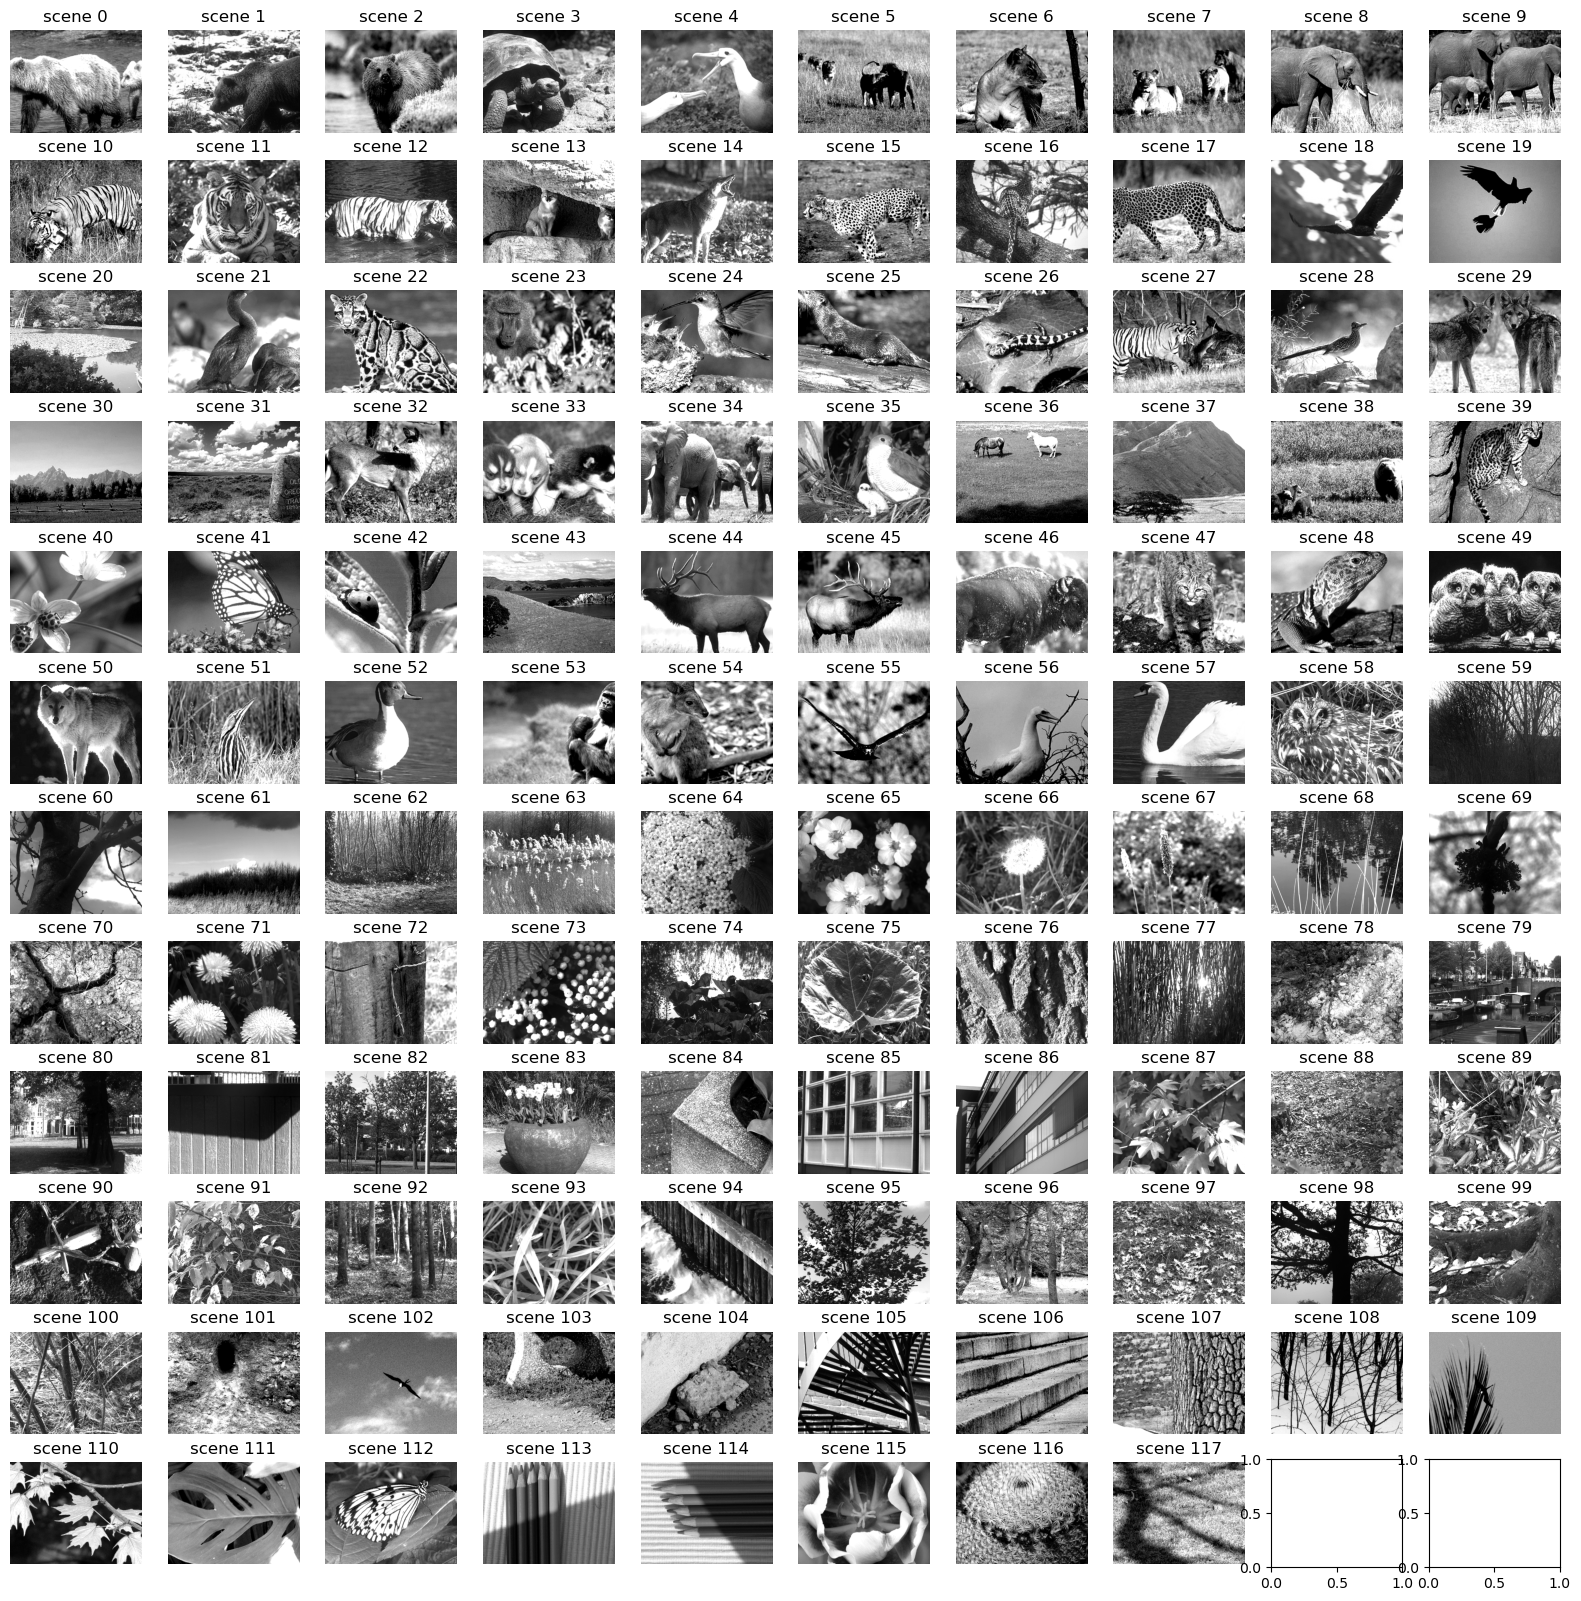

In [5]:
try:
    fig, axes = plt.subplots(12, 10, figsize=(20, 20))
    for i, ax in enumerate(axes.flat):
        ax.imshow(scenes[i], cmap='gray')
        ax.set_axis_off()
        ax.set_title('scene %d' % i)
except IndexError:
    pass # ignore the IndexError and continue running the code

- Below shows when two different images were shown.

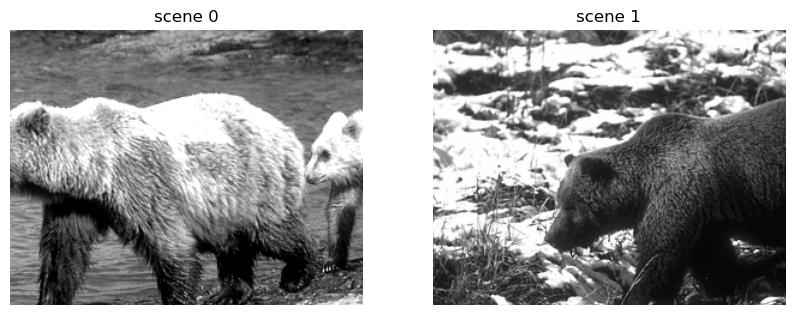

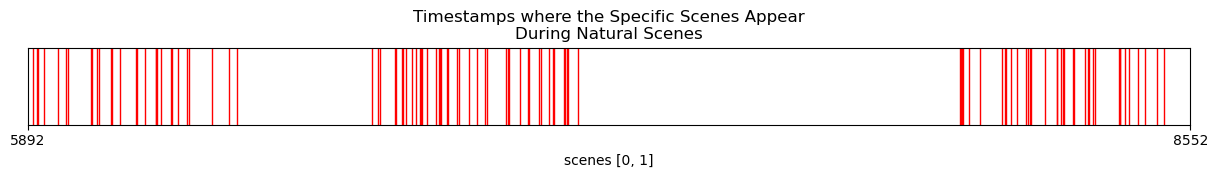

In [18]:
scene_nums = [0,1]  # scenes to inspect

def plot_stimulus_table(ns_df, title, full_start=None, full_end=None):
    # If full_start/end provided, use them to place bars within the full session range
    fstart = ns_df.start_time.min() if full_start is None else full_start
    fend   = ns_df.stop_time.max()  if full_end   is None else full_end

    fig, ax = plt.subplots(figsize=(15, 1))
    for _, trial in ns_df.iterrows():
        x1 = float(trial.start_time - fstart) / (fend - fstart)
        x2 = float(trial.stop_time  - fstart) / (fend - fstart)
        ax.add_patch(patches.Rectangle((x1, 0.0), x2 - x1, 1.0, color='r'))

    ax.set_xticks((0, 1))
    ax.set_xticklabels((int(np.round(fstart)), int(np.round(fend))))
    ax.set_yticks(())
    ax.set_title("Timestamps where the Specific Scenes Appear\nDuring Natural Scenes")
    ax.set_xlabel(title)
    plt.tight_layout()

# Natural Scenes image stack (shared across experiments)
scenes = data_set.get_stimulus_template('natural_scenes')

# Show the requested scenes (handle 1 or many)
n = len(scene_nums)
fig, axes = plt.subplots(1, n, figsize=(10, 4))
axes = np.atleast_1d(axes)
for ax, s in zip(axes, scene_nums):
    ax.imshow(scenes[s], cmap='gray')
    ax.set_axis_off()
    ax.set_title(f'scene {s}')

# Filter the table to those scenes (avoid -1 omissions)
full_ns = natural_scenes  # keep original for full-session bounds if desired
filtered_ns = full_ns[full_ns['frame'].isin(scene_nums)].copy()

# Plot occurrences; to show within the full session, pass full bounds:
plot_stimulus_table(
    filtered_ns,
    title=f"scenes {scene_nums}",
    full_start=full_ns.start_time.min(),
    full_end=full_ns.stop_time.max()
)

### 2.2) Visualize the mean extracellular spike waveform of different single units (putative neurons).

The distinct spike waveform shape and amplitude (often on the peak channel) helps differentiate units.

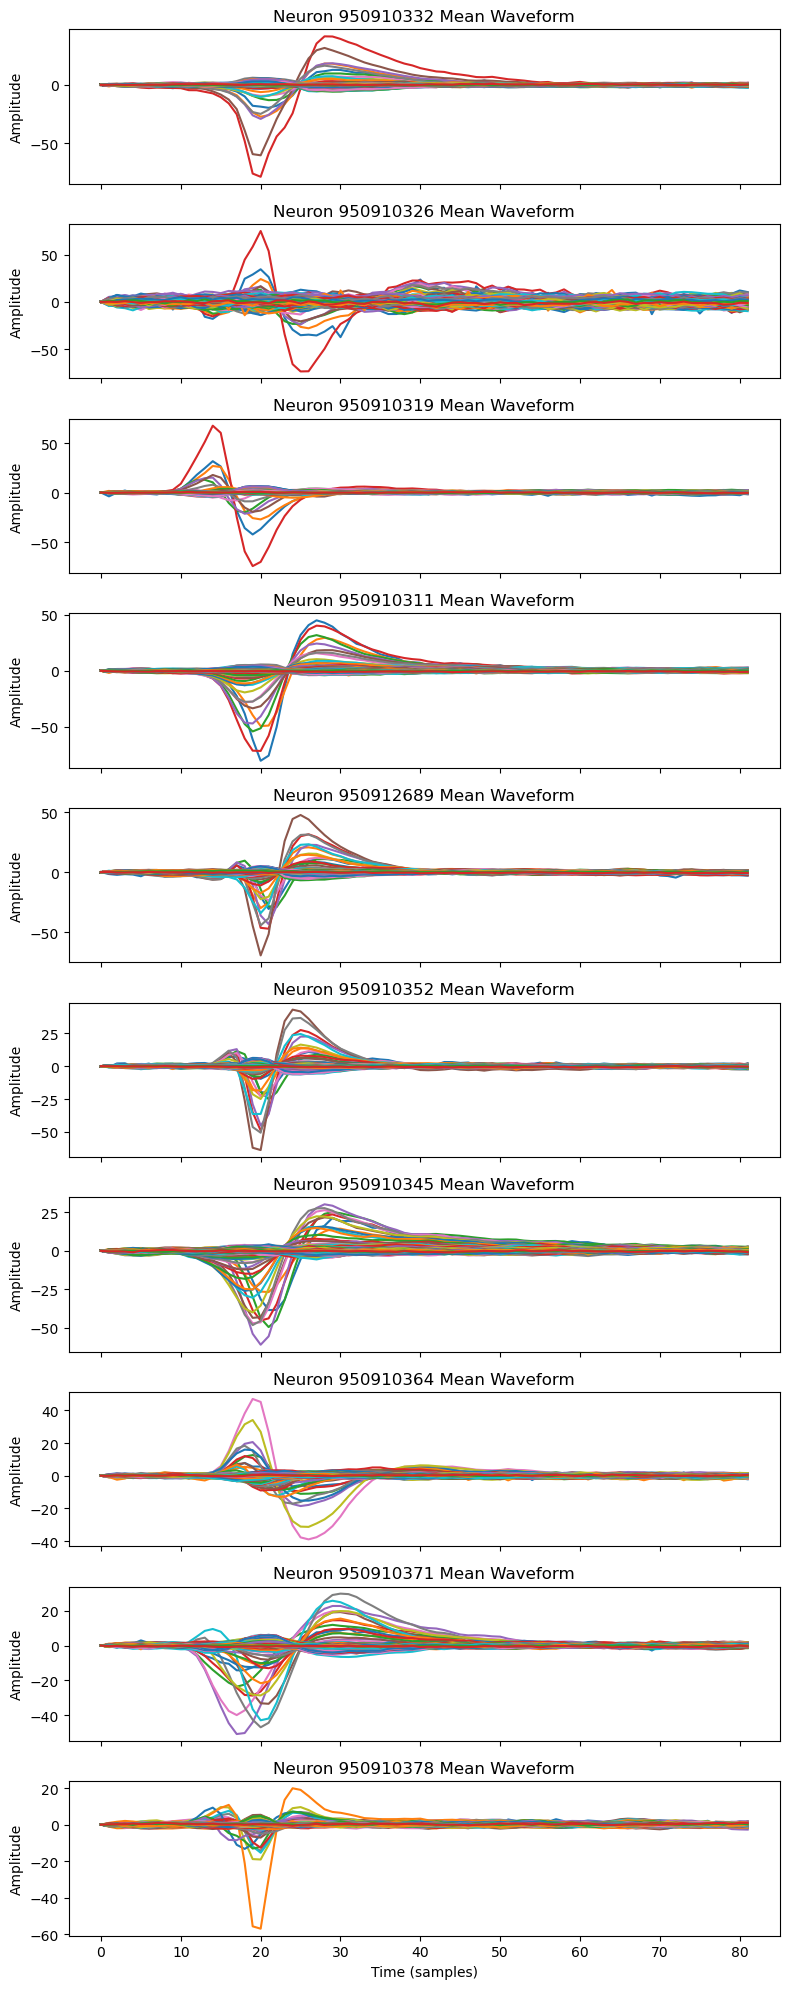

In [19]:
# Get the mean spike waveforms for each neuron
mean_waveforms = session.mean_waveforms

# Number of waveforms to display (you can change this value)
n_waveforms = 10
unit_ids = session.units.index.values

# Plot the mean spike waveforms for the first n_waveforms neurons
fig, axes = plt.subplots(n_waveforms, 1, figsize=(8, 2 * n_waveforms), sharex=True)
for i, (unit_id, ax) in enumerate(zip(unit_ids[:n_waveforms], axes)):
    waveform = mean_waveforms[unit_id]
    ax.plot(waveform.T)
    ax.set_title(f'Neuron {unit_id} Mean Waveform')
    ax.set_ylabel('Amplitude')
    ax.label_outer()

plt.xlabel('Time (samples)')
plt.tight_layout()
plt.show()


### 2.3) Raster plot of the spike trains for single units over the course of the natural scene testing. 

When the spike trains are created for each unique unit, they produce a 1 for every spike and 0 if they are not spiking at each timestep. The spike trains are plotted below for a few unique units over the natural scene time frame.

*** Add Raster Plot for binned data. ***

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os

# Create a function to build a raster plot with specified requirements.
def visualize_spike_data(num_units_to_visualize, all_spike_times, color_scheme='tab10', start_time=0, end_time=10, output_folder='pictures'):
    # Select a random subset of units to plot
    available_unit_ids = list(all_spike_times.keys())
    subset_unit_ids = random.sample(available_unit_ids, num_units_to_visualize)

    # Filter out units that do not fire within the specified timeframe
    active_units = []
    for unit_id in subset_unit_ids:
        spike_times = all_spike_times[unit_id]
        filtered_spike_times = [t for t in spike_times if start_time <= t <= end_time]
        if filtered_spike_times:
            active_units.append(unit_id)

    # Get the colormap
    cmap = plt.get_cmap(color_scheme)

    # Create the raster plot
    fig, ax = plt.subplots(figsize=(14, 8))  # Increase figure size

    for i, unit_id in enumerate(active_units):
        spike_times = all_spike_times[unit_id]

        # Filter the spike times based on start_time and end_time
        filtered_spike_times = [t for t in spike_times if start_time <= t <= end_time]

        # Assign a random color from the colormap
        random_color = cmap(i % cmap.N)

        ax.scatter(filtered_spike_times, [i] * len(filtered_spike_times), marker='|', color=random_color)

    ax.set_xlim([start_time, end_time])
    ax.set_xticks([])  # Remove x-tick labels
    ax.set_xlabel('Over 100 Seconds', fontsize=18)  # Increase x-axis label size
    ax.set_ylabel('20 Different Units', fontsize=18)  # Increase y-axis label size
    ax.set_yticks([])
    ax.set_title('Sample of Spike Trains Produced', fontsize=22)  # Increase title size

    # Ensure the output directory exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Save the figure
    output_path = os.path.join(output_folder, 'spike_trains_plot.png')
    plt.savefig(output_path)
    plt.show()

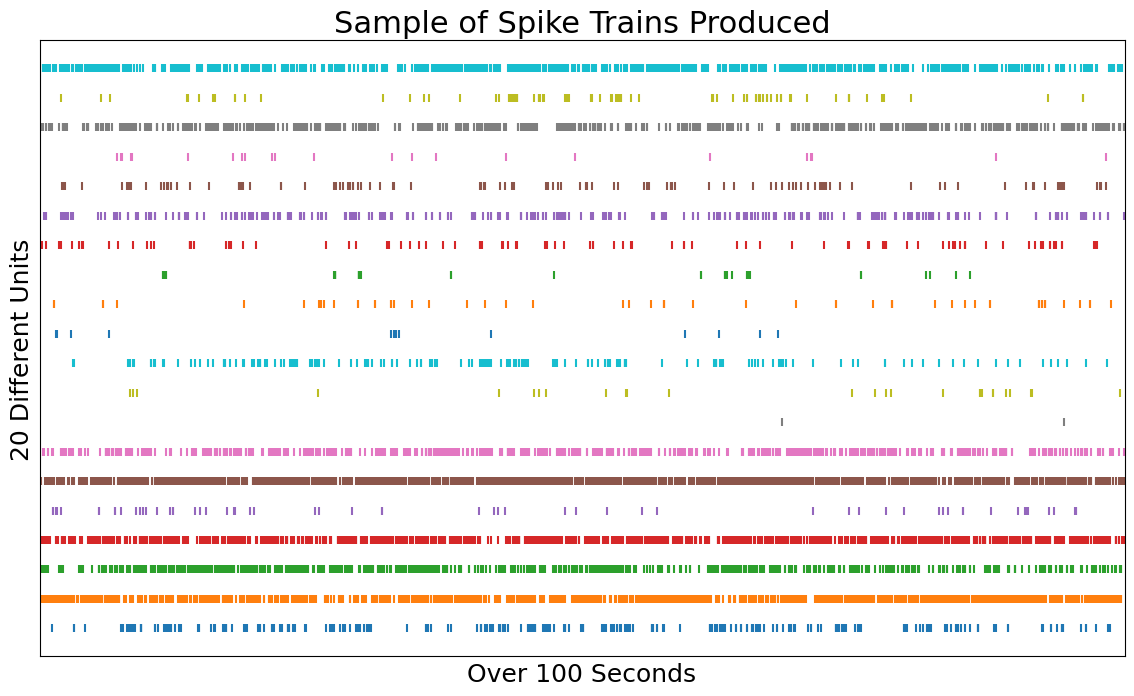

In [9]:
# Example usage:
num_units_to_visualize = 20
available_unit_ids = session.spike_times.keys()
all_spike_times = {unit_id: session.spike_times[unit_id] for unit_id in available_unit_ids}
start_time = 100  # Starting from 0
end_time = 200  # Ending at 10 seconds (can be changed to any value)
color_scheme = 'tab10'

visualize_spike_data(num_units_to_visualize, all_spike_times, color_scheme, start_time, end_time)

### 2.4) Sorted correlation matrix between single units.

Below is a sorted correlation matrix between units based on their average firing rates per image for each neuron. A clustering method called Agglomerative hierarchical cluster was group the correlation matrix.  

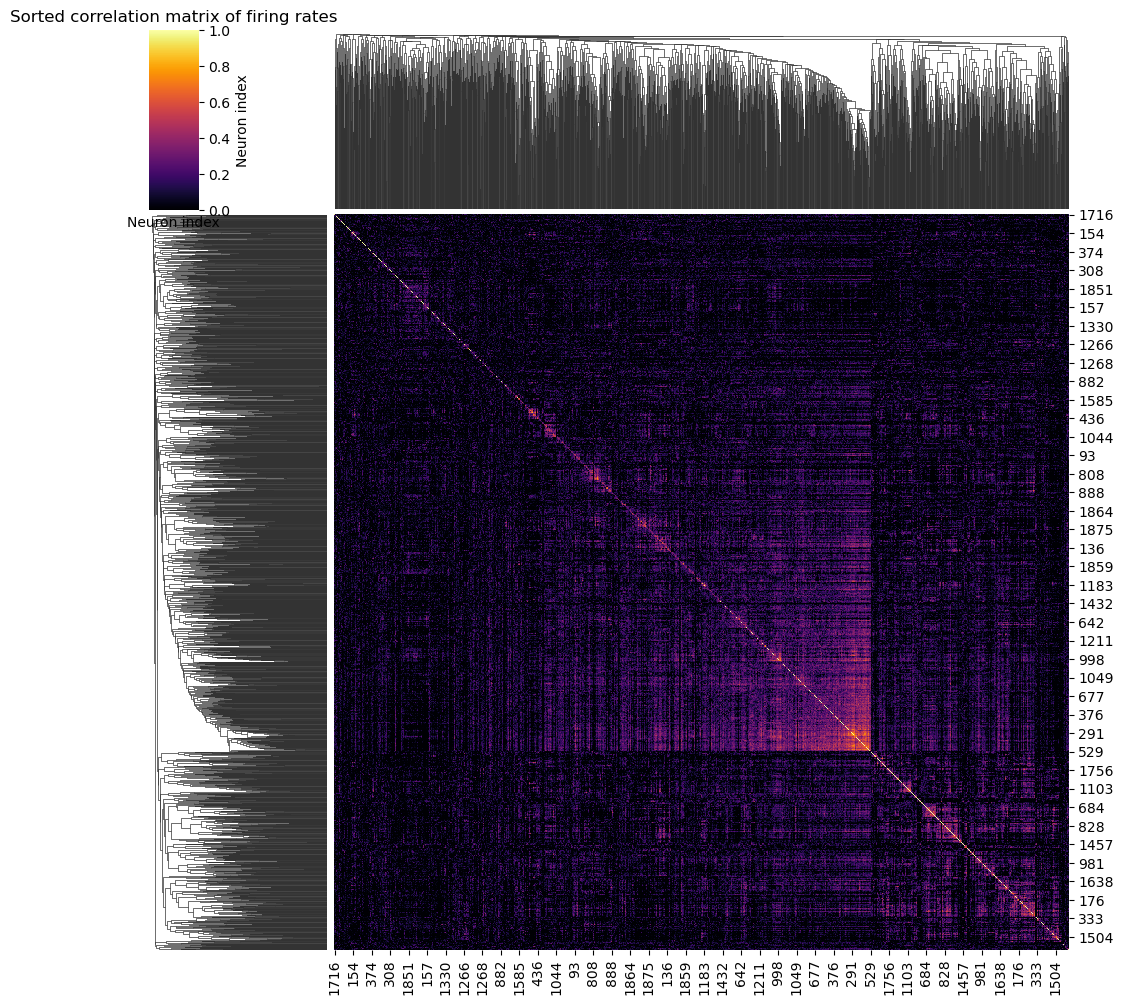

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

X = filtered_normalized_avg_spikes_per_image_250ms.drop(columns=['frame'])

### This function calculates the correlation coefficient between each pair of neurons in the input matrix X (in our case, firing rates).
def custom_corrcoef(X):
    # Calculate the correlation coefficient matrix by taking the dot product of the normalized matrix and its transpose
    # Divide the result by the number of columns in X to normalize the sum
    return np.dot(X, X.T) / X.shape[1]

# Calculate the correlation matrix
corr_matrix = custom_corrcoef(X.T)

# Compute the hierarchical clustering
distance_matrix = 1 - np.abs(corr_matrix)
np.fill_diagonal(distance_matrix, 0)  # Set the diagonal to zero
linked = linkage(squareform(distance_matrix), method='average')  # The linkage function performs the cluster.

# Plot the heatmap with dendrogram-based sorting
sns.clustermap(corr_matrix, cmap='inferno', row_linkage=linked, col_linkage=linked, vmin=0, vmax=1)
plt.title("Sorted correlation matrix of firing rates")
plt.xlabel("Neuron index")
plt.ylabel("Neuron index")
plt.show()

### 2.5) Grouped heat maps of unit responses by frames.

#### 2.5.1) Heat maps of unit responses by all frames.

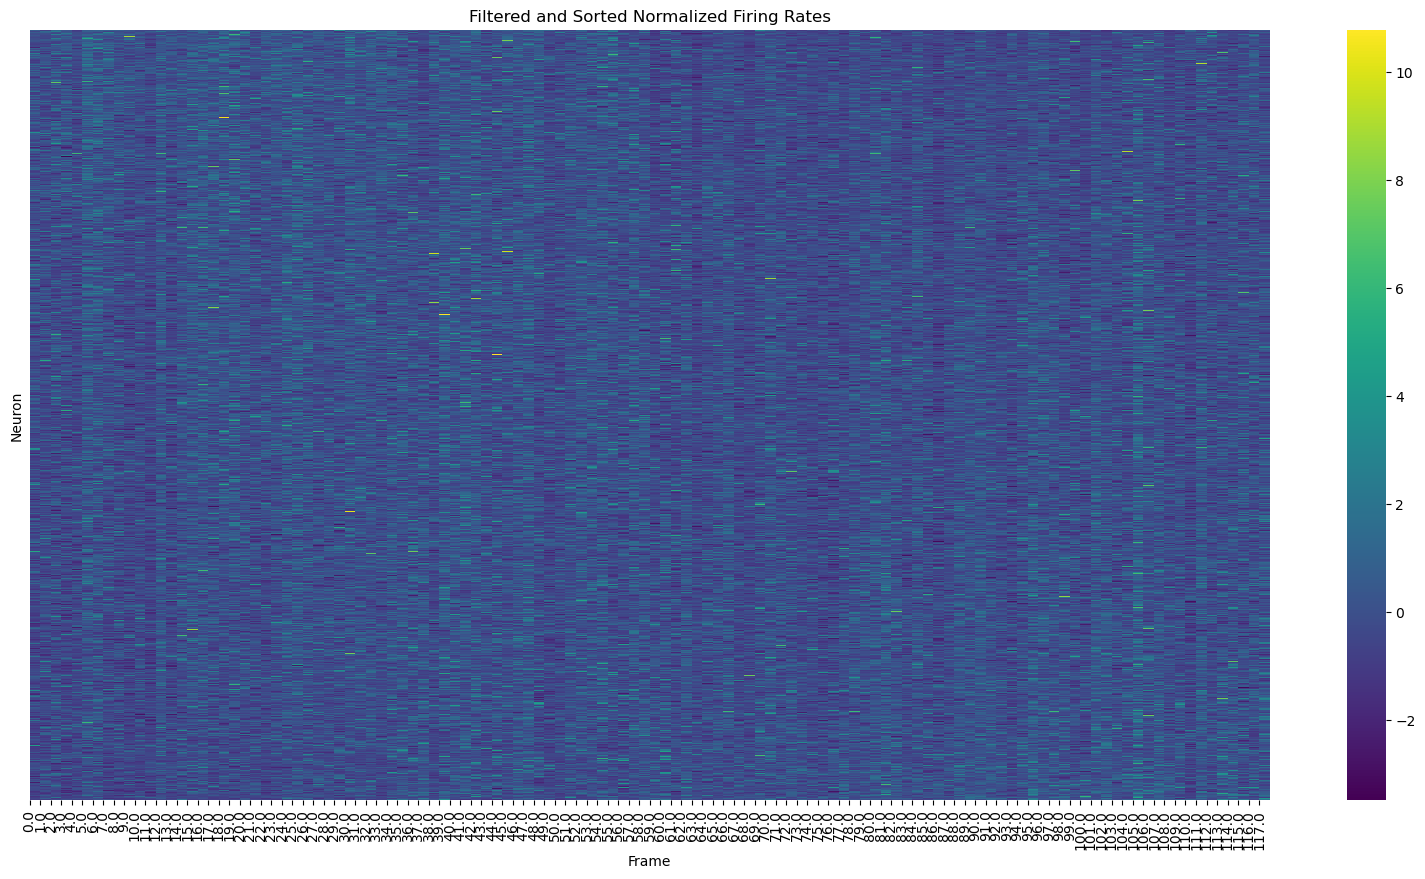

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

def plot_filtered_normalized_firing_rates(df, num_frames):
    # Calculate the correlation between the firing rates and frames
    correlation_matrix = df.corrwith(df['frame'], method='spearman')

    # Sort neurons by their correlation with the 'frame' column
    sorted_neurons = correlation_matrix[df.columns[1:]].sort_values().index.tolist()

    # Filter the DataFrame based on the desired number of frames
    filtered_df = df.head(num_frames)

    # Sort neurons by their correlation with the 'frame' column
    sorted_filtered_df = filtered_df[['frame'] + sorted_neurons]

    # Sort the DataFrame by the 'frame' column
    sorted_filtered_df.sort_values(by='frame', inplace=True)

    # Set the 'frame' column as the index of the DataFrame
    sorted_filtered_df.set_index('frame', inplace=True)

    # Create a heatmap for the filtered and sorted DataFrame
    plt.figure(figsize=(20, 10))
    ax = sns.heatmap(sorted_filtered_df.T, cmap='viridis', yticklabels=False)

    # Get unique frame values
    unique_frames = sorted_filtered_df.index.unique()

    # Set x-ticks at the middle of each frame group
    ax.set_xticks([np.where(sorted_filtered_df.index == frame)[0].mean() for frame in unique_frames])

    # Set x-tick labels to be the frame numbers
    ax.set_xticklabels(unique_frames)

    plt.xlabel('Frame')
    plt.ylabel('Neuron')
    plt.title(f'Filtered and Sorted Normalized Firing Rates')
    plt.show()

# Use the function with the desired parameters
plot_filtered_normalized_firing_rates(filtered_normalized_avg_spikes_per_image_250ms, num_frames=None)

#### 2.5.2) Heat maps of unit responses by select number of frames.

/nas/longleaf/home/dkofma60/.local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


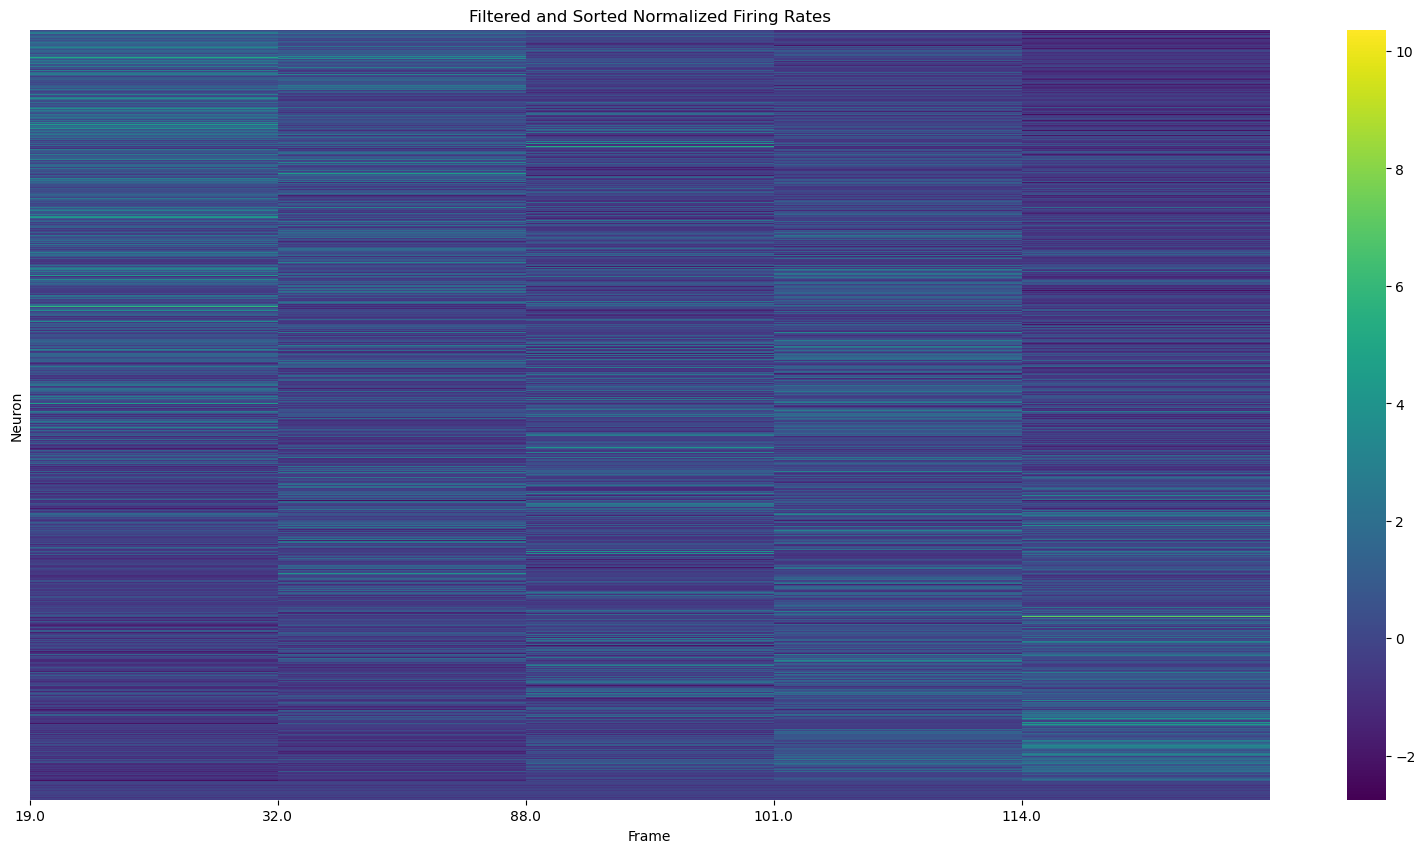

In [16]:
# Select how many neurons to show.
neurons_to_show = 5

frames_to_select = np.random.randint(0, 117 + 1, neurons_to_show)
select_images = filtered_normalized_avg_spikes_per_image_250ms[filtered_normalized_avg_spikes_per_image_250ms['frame'].isin(frames_to_select)]
select_images

plot_filtered_normalized_firing_rates(select_images, num_frames=None)

/nas/longleaf/home/dkofma60/.local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


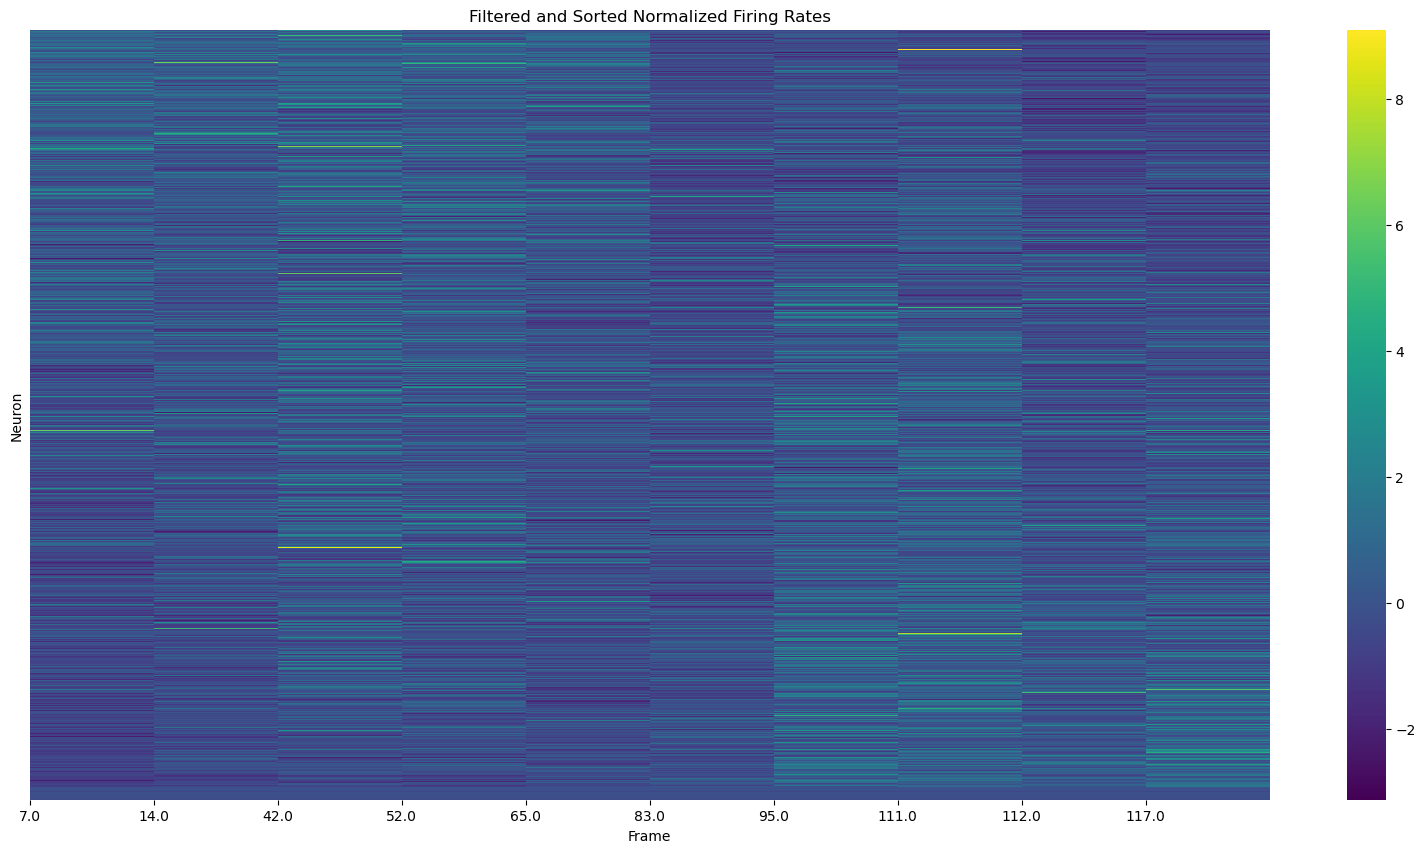

In [18]:
# Select how many neurons to show.
neurons_to_show = 10

frames_to_select = np.random.randint(0, 117 + 1, neurons_to_show)
select_images = filtered_normalized_avg_spikes_per_image_250ms[filtered_normalized_avg_spikes_per_image_250ms['frame'].isin(frames_to_select)]
select_images

plot_filtered_normalized_firing_rates(select_images, num_frames=None)

### 2.6) Average firing rates of units during each frame, in Hertz and by Z scores.

#### 2.6.1) Average firing rates of chosen number of units during each frames, in Hertz.

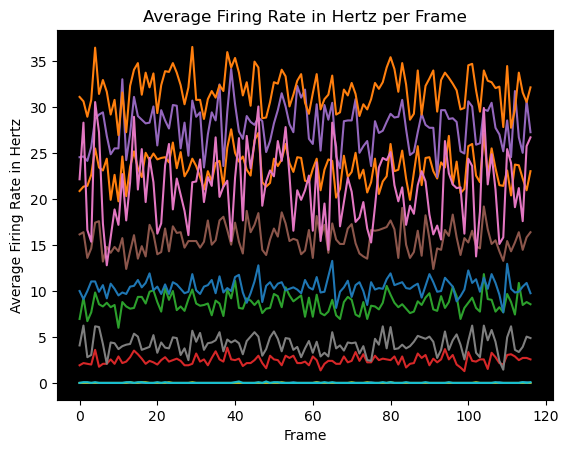

In [20]:
# Calculate the spikes per second.
spikes_per_image = raw_spikes_per_frame.groupby('frame').mean().iloc[1:,1:]
spikes_per_image.reset_index(inplace=True)
firing_rate_hz = spikes_per_image * 4
firing_rate_hz['frame'] = spikes_per_image['frame']

# Choose how many neurons to display.
num_of_neurons_display = 12

# Set the background color to black
plt.rcParams['axes.facecolor'] = 'black'

# Plot the firing rate for each neuron
firing_rate_hz.iloc[:,1:(num_of_neurons_display+1)].plot(kind='line', legend=False)

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Average Firing Rate in Hertz')
plt.title('Average Firing Rate in Hertz per Frame')

# Show the plot
plt.show()

#### 2.6.2) Average firing rates of all units during each frames, in Hertz.

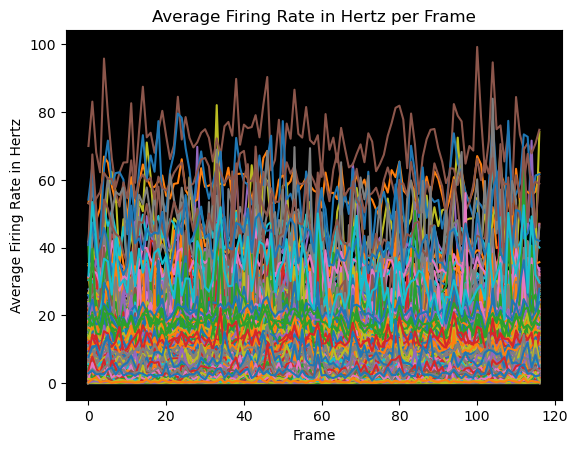

In [21]:
# Set the background color to black
plt.rcParams['axes.facecolor'] = 'black'

# Plot the firing rate for each neuron
firing_rate_hz.iloc[:,1:].plot(kind='line', legend=False)

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Average Firing Rate in Hertz')
plt.title('Average Firing Rate in Hertz per Frame')

# Show the plot
plt.show()

#### 2.6.3)  Average firing rates of all normalized units during each frames, in Hertz.

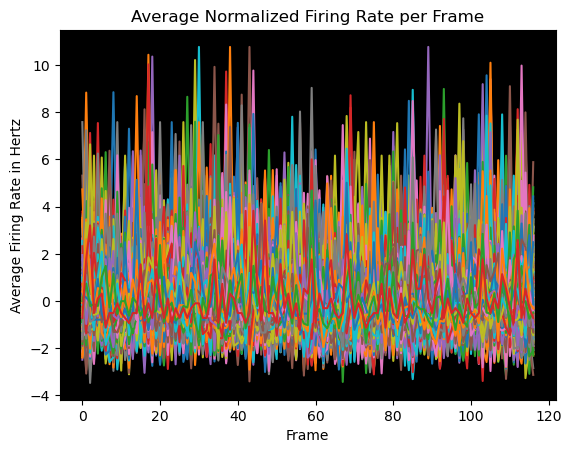

In [23]:
normalized_spikes_per_frame = filtered_normalized_avg_spikes_per_image_250ms.groupby('frame').mean().iloc[1:,1:]
normalized_spikes_per_frame.reset_index(inplace=True)

# Set the background color to black
plt.rcParams['axes.facecolor'] = 'black'

# Plot the firing rate for each neuron
normalized_spikes_per_frame.iloc[:,1:].plot(kind='line', legend=False)

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Average Firing Rate in Hertz')
plt.title('Average Normalized Firing Rate per Frame')

# Show the plot
plt.show()

#### 2.6.4)  Average firing rates of chosen normalized units during each frames, in Hertz.

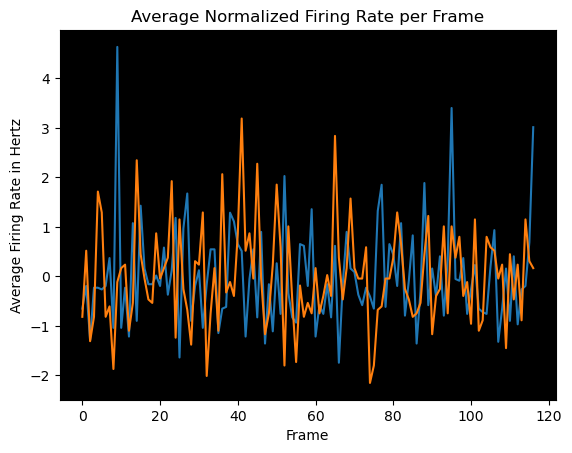

In [24]:
# Drop the 'frame' column to avoid including it in the plot
normalized_spikes_per_frame_no_index = normalized_spikes_per_frame.drop(columns=['frame'])

num_units_to_plot = 2

# Drop the 'frame' column to avoid including it in the plot
normalized_spikes_per_frame_no_index = normalized_spikes_per_frame.drop(columns=['frame'])

# Randomly select a subset of columns for plotting
random_units = normalized_spikes_per_frame_no_index.sample(n=num_units_to_plot, axis=1, random_state=np.random.randint(0, 1000))

# Plot the selected subset
random_units.plot(kind='line', legend=False)

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Average Firing Rate in Hertz')
plt.title('Average Normalized Firing Rate per Frame')

# Show the plot
plt.show()

<a name="step3content"></a>
## 3. Image Prediction Modeling
[Go to Outline](#outline)

    The goal of the image prediction modeling is to predict what image is shown based on the neuropixel data given.

- 3.0) Create train splits, test splits.
- 3.1) Baseline Model: a random guess with an accuracy of 0.85% (1/118).
- 3.2) Multivariate Logistic Regressions (MVLR)
- 3.3) Principal Component to MVLR (PC-MVLR)
- 3.4) Support Vector Classifier (SVC)
- 3.5) Neural Network with one hidden layer.
- 3.6) Neural Network with multiple hidden layers.
- 3.7) Graph Convolution Network(GCN).
- 3.8) Graph Attention Network(GAT).
- 3.9) Long Short-Term Memory(LSTM).
- 3.10) Spatio-Temporal Graph Attention Network(ST-GAT).
- 3.11) Transformer.

</div>
<img src="pictures/ST-GNN Variant Flow Chart.png" width="500" height="800" alt="Alt text"/>
</div>

### 3.0) Create train splits and test splits for non-temporal models.

Note: This section does not load in the temporal data. The temporal models all load in the temporal data based on set time steps.

In [6]:
import pickle
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

spike_trains_file_path = 'output/spike_trains_with_stimulus_session_715093703_1.pkl'

with open(spike_trains_file_path, 'rb') as f:
    spike_df_average_rate = pickle.load(f)

print(f"Loaded spike trains dataset: {type(spike_df_average_rate)}")

def prepare_data(dataframe):
    X = dataframe.iloc[:, :-1].values
    y = dataframe.iloc[:, -1].values
    return X, y

def remove_0_columns(X):
    std_devs = np.std(X, axis=0)
    zero_std_columns = np.where(std_devs == 0)[0]
    if len(zero_std_columns) > 0:
        X = np.delete(X, zero_std_columns, axis=1)
    return X

# Prepare the data
X, y = prepare_data(spike_df_average_rate.copy())
X = remove_0_columns(X)
y = y.astype(np.float32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
print(f'X_train shape = {np.shape(X_train)}')
print(f'X_test shape = {np.shape(X_test)}')
print(f'y_train shape = {np.shape(y_train)}')
print(f'y_test shape = {np.shape(y_test)}')

Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
X_train shape = (4760, 2065)
X_test shape = (1190, 2065)
y_train shape = (4760,)
y_test shape = (1190,)


### 3.1) Baseline Model.

    The baseline model assumes a random guess, with an accuracy of 0.85% (1/117).

In [7]:
print(f'Test Accuracy: {np.round(1/117*100, 2)}%')

Test Accuracy: 0.85%


### 3.2) Multivariate Logistic Regression.

In [9]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# Number of classes
num_classes = 118

# Create a list to hold the models for each class
models = []

# Train a separate model for each class
for class_idx in range(num_classes):
    # Create the binary target for the current class
    y_train_binary = (y_train == class_idx).astype(int)
    
    # Create a pipeline for scaling and regression
    model = make_pipeline(StandardScaler(), Ridge())
    
    # Fit the model
    model.fit(X_train, y_train_binary)
    
    # Append the model to the list
    models.append(model)

# Predict on the test set
predictions = np.zeros((X_test.shape[0], num_classes))

for class_idx, model in enumerate(models):
    predictions[:, class_idx] = model.predict(X_test)

# Select the class with the highest predicted value for each sample
y_pred = np.argmax(predictions, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print detailed classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Accuracy: 82.86%
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        15
         0.0       0.88      0.88      0.88         8
         1.0       0.90      0.90      0.90        10
         2.0       1.00      0.71      0.83        14
         3.0       1.00      1.00      1.00         8
         4.0       0.00      0.00      0.00         8
         5.0       0.85      0.92      0.88        12
         6.0       0.92      0.92      0.92        12
         7.0       0.88      1.00      0.93         7
         8.0       0.70      1.00      0.82         7
         9.0       0.86      0.75      0.80         8
        10.0       1.00      1.00      1.00         5
        11.0       0.67      0.67      0.67         6
        12.0       1.00      0.86      0.92        14
        13.0       1.00      0.89      0.94         9
        14.0       1.00      0.92      0.96        12
        15.0       0.90      0.82      0.86        11
        16

### 3.3) Run Principal Component to MVLR

In [8]:
### A basic PCR.
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a pipeline for PCR
for i in np.arange(1, 20, 2):
    n_components = i  # Adjust the number of components based on your data
    pcr = Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('linear_regression', LinearRegression())
    ])

    # Train the PCR model
    pcr.fit(X_train, y_train)

    # Predict the test set
    y_pred = pcr.predict(X_test)

    # Convert predictions and true labels to integers (since you mentioned that each number represents a picture)
    y_pred_int = np.round(y_pred).astype(int)
    y_test_int = y_test.astype(int)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test_int, y_pred_int)
    print(f"PCR accuracy with {n_components} Principal Components: {np.round(accuracy*100, 2)}%")

# Create a pipeline for PCR
for i in np.arange(20, 110, 10):
    n_components = i  # Adjust the number of components based on your data
    pcr = Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('linear_regression', LinearRegression())
    ])

    # Train the PCR model
    pcr.fit(X_train, y_train)

    # Predict the test set
    y_pred = pcr.predict(X_test)

    # Convert predictions and true labels to integers (since you mentioned that each number represents a picture)
    y_pred_int = np.round(y_pred).astype(int)
    y_test_int = y_test.astype(int)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test_int, y_pred_int)
    print(f"PCR accuracy with {n_components} Principal Components: {np.round(accuracy*100, 2)}%")

PCR accuracy with 1 Principal Components: 0.84%
PCR accuracy with 3 Principal Components: 0.67%
PCR accuracy with 5 Principal Components: 0.92%
PCR accuracy with 7 Principal Components: 0.92%
PCR accuracy with 9 Principal Components: 0.76%
PCR accuracy with 11 Principal Components: 1.34%
PCR accuracy with 13 Principal Components: 0.84%
PCR accuracy with 15 Principal Components: 0.08%
PCR accuracy with 17 Principal Components: 0.92%
PCR accuracy with 19 Principal Components: 0.67%
PCR accuracy with 20 Principal Components: 1.09%
PCR accuracy with 30 Principal Components: 0.5%
PCR accuracy with 40 Principal Components: 1.01%
PCR accuracy with 50 Principal Components: 1.26%
PCR accuracy with 60 Principal Components: 1.09%
PCR accuracy with 70 Principal Components: 1.43%
PCR accuracy with 80 Principal Components: 1.09%
PCR accuracy with 90 Principal Components: 0.92%
PCR accuracy with 100 Principal Components: 1.6%


### 3.4) SVM with a Radial Kernel

In [11]:
from sklearn.svm import SVR

# Create and train the SVM model with a radial kernel
model = SVR(kernel='rbf', C=10, gamma='scale')
model.fit(X_train, y_train)

# Make predictions on the test set and round them to the nearest integer
y_pred = model.predict(X_test)
y_pred_rounded = [round(pred) for pred in y_pred]

# Calculate the accuracy of the model
correct_predictions = np.sum(np.equal(y_test, y_pred_rounded))
accuracy = correct_predictions / len(y_test) * 100

print(f"SVM Accuracy: {accuracy:.2f}%")

SVM Accuracy: 1.34%


### 3.5) Neural Network with one hidden layer.

Supports the use of Deep neural netowrks over linear models. http://cs230.stanford.edu/projects_winter_2021/reports/70532925.pdf

Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
Epoch [1/50], Test accuracy: 10.68%
Epoch [2/50], Test accuracy: 54.24%
Epoch [3/50], Test accuracy: 75.51%
Epoch [4/50], Test accuracy: 72.88%
Epoch [5/50], Test accuracy: 82.54%
Epoch [6/50], Test accuracy: 85.76%
Epoch [7/50], Test accuracy: 86.61%
Epoch [8/50], Test accuracy: 86.53%
Epoch [9/50], Test accuracy: 87.71%
Epoch [10/50], Test accuracy: 87.80%
Epoch [11/50], Test accuracy: 90.51%
Epoch [12/50], Test accuracy: 91.53%
Epoch [13/50], Test accuracy: 92.29%
Epoch [14/50], Test accuracy: 92.20%
Epoch [15/50], Test accuracy: 92.03%
Epoch [16/50], Test accuracy: 91.95%
Epoch [17/50], Test accuracy: 91.95%
Epoch [18/50], Test accuracy: 91.86%
Epoch [19/50], Test accuracy: 91.78%
Epoch [20/50], Test accuracy: 91.69%
Epoch [21/50], Test accuracy: 91.44%
Epoch [22/50], Test accuracy: 91.36%
Epoch [23/50], Test accuracy: 91.44%
Epoch [24/50], Test accuracy: 91.44%
Epoch [25/50], Test accuracy: 91.36%
Epoch [26/50], Te

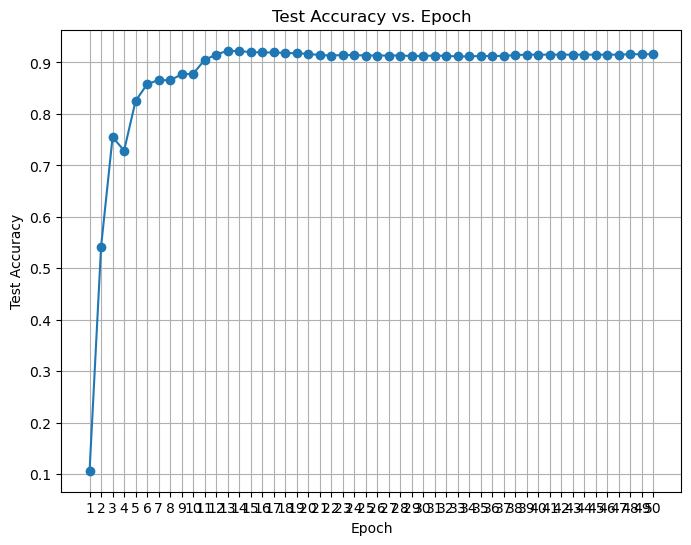

In [14]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

spike_trains_file_path = 'output/spike_trains_with_stimulus_session_715093703_1.pkl'

with open(spike_trains_file_path, 'rb') as f:
    spike_df = pickle.load(f)
    print(f"Loaded spike trains dataset: {type(spike_df)}")

def prepare_data(dataframe):
    X = dataframe.iloc[:, :-1].values
    y = dataframe.iloc[:, -1].values
    return X, y

def remove_0_columns(X):
    std_devs = np.std(X, axis=0)
    zero_std_columns = np.where(std_devs == 0)[0]
    if len(zero_std_columns) > 0:
        X = np.delete(X, zero_std_columns, axis=1)
    return X

# Prepare the data
X, y = prepare_data(spike_df)
X = remove_0_columns(X)

# Convert y to numeric data type
y = y.astype(np.int64)

# Drop rows with negative labels
mask = y >= 0
X = X[mask]
y = y[mask]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
#print('X_train shape =', X_train.shape, 'X_test shape =', X_test.shape)
#print('y_train shape =', y_train.shape, 'y_test shape =', y_test.shape)

# Check the unique values in y_train and y_test
#print("Unique values in y_train:", np.unique(y_train))
#print("Unique values in y_test:", np.unique(y_test))

# Convert data to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

# Create the neural network model
class Net(nn.Module):
    def __init__(self, input_dim, hidden_layer_size, num_layers, num_classes):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_layer_size))
        self.layers.append(nn.ReLU())
        
        for i in range(1, num_layers):
            layer_size = hidden_layer_size // (2 ** i)
            self.layers.append(nn.Linear(self.layers[-2].out_features, layer_size))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(self.layers[-2].out_features, num_classes))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Set the number of layers, hidden layer size, and number of classes
num_layers = 1
hidden_layer_size = 1500
num_classes = len(np.unique(y))

# Create the model and optimizer
model = Net(X_train.shape[1], hidden_layer_size, num_layers, num_classes)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

test_accuracies = []

# Train the model
num_epochs = 50
batch_size = 32
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    # Evaluate the model
    with torch.no_grad():
        y_pred = model(X_test)
        _, y_pred_class = torch.max(y_pred, dim=1)
        accuracy = accuracy_score(y_test.numpy(), y_pred_class.numpy())
        test_accuracies.append(accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Test accuracy: {accuracy * 100:.2f}%")

# Create the graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Epoch')
plt.xticks(range(1, num_epochs + 1))
plt.grid(True)
plt.show()

### 3.6) Multi-hidden Layer Neural Network

*** Need to finish wrap code in tuner.

In [15]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

spike_trains_file_path = 'output/spike_trains_with_stimulus_session_715093703_1.pkl'

with open(spike_trains_file_path, 'rb') as f:
    spike_df = pickle.load(f)
    print(f"Loaded spike trains dataset: {type(spike_df)}")

def prepare_data(dataframe):
    X = dataframe.iloc[:, :-1].values
    y = dataframe.iloc[:, -1].values
    return X, y

def remove_0_columns(X):
    std_devs = np.std(X, axis=0)
    zero_std_columns = np.where(std_devs == 0)[0]
    if len(zero_std_columns) > 0:
        X = np.delete(X, zero_std_columns, axis=1)
    return X

# Prepare the data
X, y = prepare_data(spike_df)
X = remove_0_columns(X)

# Convert y to numeric data type
y = y.astype(np.int64)

# Drop rows with negative labels
mask = y >= 0
X = X[mask]
y = y[mask]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
#print('X_train shape =', X_train.shape, 'X_test shape =', X_test.shape)
#print('y_train shape =', y_train.shape, 'y_test shape =', y_test.shape)

# Check the unique values in y_train and y_test
#print("Unique values in y_train:", np.unique(y_train))
#print("Unique values in y_test:", np.unique(y_test))

# Convert data to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

# Create the neural network model
class Net(nn.Module):
    def __init__(self, input_dim, hidden_layer_size, num_layers, num_classes):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_layer_size))
        self.layers.append(nn.ReLU())
        
        for i in range(1, num_layers):
            layer_size = hidden_layer_size // (2 ** i)
            self.layers.append(nn.Linear(self.layers[-2].out_features, layer_size))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(self.layers[-2].out_features, num_classes))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Set the number of layers, hidden layer size, and number of classes
num_layers = 2
hidden_layer_size = 750
num_classes = len(np.unique(y))

# Create the model and optimizer
model = Net(X_train.shape[1], hidden_layer_size, num_layers, num_classes)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Train the model
num_epochs = 50
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    

    # Evaluate the model
    with torch.no_grad():
        y_pred = model(X_test)
        _, y_pred_class = torch.max(y_pred, dim=1)
        accuracy = accuracy_score(y_test.numpy(), y_pred_class.numpy())
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test accuracy: {accuracy * 100:.2f}%")

Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
Epoch [1/50], Loss: 4.8576, Test accuracy: 1.36%
Epoch [2/50], Loss: 3.6968, Test accuracy: 11.36%
Epoch [3/50], Loss: 2.1808, Test accuracy: 37.97%
Epoch [4/50], Loss: 1.1314, Test accuracy: 42.46%
Epoch [5/50], Loss: 0.7521, Test accuracy: 59.83%
Epoch [6/50], Loss: 0.4363, Test accuracy: 60.68%
Epoch [7/50], Loss: 0.2262, Test accuracy: 64.24%
Epoch [8/50], Loss: 0.2304, Test accuracy: 53.98%
Epoch [9/50], Loss: 0.0697, Test accuracy: 70.25%
Epoch [10/50], Loss: 0.2425, Test accuracy: 70.59%
Epoch [11/50], Loss: 0.0913, Test accuracy: 71.44%
Epoch [12/50], Loss: 0.1048, Test accuracy: 73.14%
Epoch [13/50], Loss: 0.0075, Test accuracy: 77.46%
Epoch [14/50], Loss: 0.0058, Test accuracy: 75.51%
Epoch [15/50], Loss: 0.0221, Test accuracy: 70.93%
Epoch [16/50], Loss: 0.0046, Test accuracy: 77.37%
Epoch [17/50], Loss: 0.0024, Test accuracy: 83.31%
Epoch [18/50], Loss: 0.0041, Test accuracy: 79.24%
Epoch [19/50], Loss: 0.00

In [16]:
# Need to fix
from auto_hyperparameter_tuner import *
from torch.cuda.amp import GradScaler, autocast

param_space = {
    "wandb_project": "Predicting Visual Stimulus",
    "wandb_api_key": "7c8d251196fd96d2a93bfb6ffd0005ac030ce42b",
    "num_epochs": 50,
    "lr": tune.uniform(.001, .0001),
    "early_stop_patience": 2,
    "early_stop_delta": 0.01,
    "batch_size": 16,
    "mouse_number": 715093703,
    "timesteps": 1,
    "Architecture": 'MLNN',
    "num_samples": 100,
    "accumulation_steps": tune.choice([4]),  # Gradient accumulation
    "hidden_dim": tune.choice([32, 64, 128]),
    "num_layers": tune.choice([2, 3, 4]),
    "file_path": "/proj/STOR/pipiras/Neuropixel/output/spike_trains_with_stimulus_session_715093703_1.pkl"
}

trainer = ModelTrainer(param_space)
trainer.execute_tuning()

ModuleNotFoundError: No module named 'auto_hyperparameter_tuner'

### 3.7) Graph Convolutional Network

This will begin with a fully connected graph between all nodes and trim nodes from that point or from a correlation matrix.
The current implementation doesn't have graph batching and will require larger compute power compared to other models in this benchmark system.
Even with batching, this is computationally expensive.

In [ ]:
from models.gat_trainer import *
from torch.cuda.amp import GradScaler, autocast

param_space = {
    "wandb_project": "Predicting Visual Stimulus",
    "wandb_api_key": "7c8d251196fd96d2a93bfb6ffd0005ac030ce42b",
    "num_epochs": 50,
    "lr": 0.0005,
    "spatial_hidden_dim": tune.randint(1,10),
    "edge_threshold": .25,
    "early_stop_patience": 3,
    "early_stop_delta": 0.01,
    "batch_size": 2,
    "mouse_number": 715093703,
    "timesteps": 1,
    "Architecture": 'GCN',
    "num_samples": 100,
    "accumulation_steps": 2,  # Gradient accumulation
    "use_auto_corr_matrix": False,
    "file_path": "/proj/STOR/pipiras/Neuropixel/output/spike_trains_with_stimulus_session_715093703_1.pkl",
    "spatial_out_features":1,
    
    # Not used in this model.
    "graph_lr": .05,  
    "graph_batch_size": 16,
    "temporal_hidden_dim": 250,    
    "temporal_layer_dimension":1 
}

trainer = ModelTrainer(param_space)
trainer.execute_tuning()

### 3.8) Graph Attention Network(GAT).

This will begin with a fully connected graph between all nodes and trim nodes from that point or from a correlation matrix.
The current implementation doesn't have graph batching and will require larger compute power compared to other models in this benchmark system.
Even with batching, this is computationally expensive.

GAT documentation: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html

In [1]:
from models.gat_trainer import *
from torch.cuda.amp import GradScaler, autocast

param_space = {
    "wandb_project": "Predicting Visual Stimulus",
    "wandb_api_key": "7c8d251196fd96d2a93bfb6ffd0005ac030ce42b",
    "num_epochs": 50,
    "lr": 0.0005,
    "spatial_hidden_dim": tune.randint(10,25),
    "edge_threshold": .25,
    "early_stop_patience": 3,
    "early_stop_delta": 0.01,
    "batch_size": 2,
    "mouse_number": 715093703,
    "timesteps": 1,
    "Architecture": 'GAT',
    "num_samples": 100,
    "accumulation_steps": 2,  # Gradient accumulation
    "use_auto_corr_matrix": False,
    "file_path": "/proj/STOR/pipiras/Neuropixel/output/spike_trains_with_stimulus_session_715093703_1.pkl",
    "spatial_out_features":1,
    "graph_lr": .05,  # Adjust the range as needed
    "graph_batch_size": 16,
    
    "temporal_hidden_dim": 250,    #remove from here
    "temporal_layer_dimension":1 #remove from here
}

trainer = ModelTrainer(param_space)
trainer.execute_tuning()

2024-05-16 10:26:54,057	INFO worker.py:1724 -- Started a local Ray instance.


KeyboardInterrupt: 

### 3.9) Long-Short Term Memory model.

   The purpose of the following Long Short-Term Memory (LSTM) model is to account for temporal dependencies while using deep learning to predict a categorical outcome. Given a sequence of inputs $x_1, . . . , x_T$, the LSTM model attempts to predict a corresponding sequence of outputs $y_1, . . . , y_{T'}$. The sequence of inputs are the firing rates of indivual units and the sequence of outputs is the log probability for each frame. It does this by two states, one for long term time dependencies and one for short term. These are referred to as the cell and hidden states. In our model, we make a prediction from the frame that has the highest log probability.

   Formally, this can be described as the LSTM model learning a probability distribution over sequences of outputs conditioned on sequences of inputs, expressed as:

$$
p(y_1, . . . , y_{T'} | x_1, . . . , x_T ) = \prod_{t=1}^{T'} p(y_t|h_{t-1}, c_{t-1}, x_t)
$$

   Where $x_t$ is the firing rate at each timestep $t$, $x_T$ is all the firing rates for each uniqe frame, $y_t$ is the log probability of the frame shown at each timestep $t$, $y_T$ is the log probability of which frame was shown for each frame. $h_{t-1}$ is the hidden state at time $t-1$, and $c_{t-1}$ is the cell state at time $t-1$.

   The ability to selectively forget information comes from its gating mechanisms. This is useful for when time dependencies might change. Each frame is shown for a quarter of a second, or 0.25 seconds. Say our data has been processed where each unique frame shown is split between 10 rows/timesteps. When we are making a prediction about each frame the model uses the output of the model from the final timestep of that frame. In this case we would only make one guess per unique frame shown. 

   This LSTM cell takes as input the current firing rate of each neuron $x_t$ and the previous hidden state $h_{t-1}$, and outputs a new hidden state $h_t$ and a new cell state $c_t$. The hidden state represents the short term memory while the cell state represents the long term memory. This process can be described by the following equations:

1. **Forget gate:**
    $$
    f_t = \sigma(W_{if} \cdot x_t + b_{if} + W_{hf} \cdot h_{t-1} + b_{hf})
    $$

2. **Input gate:**
    $$
    i_t = \sigma(W_{ii} \cdot x_t + b_{ii} + W_{hi} \cdot h_{t-1} + b_{hi})
    $$

3. **Candidate cell state:**
    $$
    g_t = \tanh(W_{ig} \cdot x_t + b_{ig} + W_{hg} \cdot h_{t-1} + b_{hg})
    $$

4. **Update cell state:**
   $$
   c_t = f_t \odot c_{t-1} + i_t \odot g_t
   $$
   
5. **Output gate:**
   $$
   o_t = \sigma(W_{io} \cdot x_t + b_{io} + W_{ho} \cdot h_{t-1} + b_{ho})
   $$
   
6. **Update hidden state:**
   $$
   h_t = o_t \odot \tanh(c_t)
   $$
  
7. **Output layer:**
   $$
   y_t = W_y \cdot h_t + b_y
   $$
  
8. **Prediction:**
   $$
   \hat{y}_t = argmax ( softmax (y_T))
   $$

      The model uses the forget gate(step 1), input gate(step 2), and the canidate cell state(step 3) to update the long term memory(step 4). It then creates the output gate(step 5), which represents the short term memory. This step only accounts for information from the current unique frame. The model then takes into account both long and short term memory by using the Hadamard product between the output gate and the $tanh$ of the cell state.
      The output ${y}_t$ is a vector of size equal to the number of classes in the output space. $\hat{y}_t$ Each element of this vector represents the score for a particular class. The class with the highest score is the model's prediction.

#### LSTM Parameters

- $x_t$: the input vector at time $t$. This is the firing rates of all neurons at time $t$. It is a vector where $m$ represents the number of features. In our case it is equal to the number of neurons in our dataset.
    $$
    x_{t} = x_{1,t} ,..., x_{m,t}
    $$    

- $h_{t-1}$: the hidden state at time $t-1$. This is the output of the LSTM cell from the previous time step. It also represents the short term memory. It is a vector. Where "n" represents the hyperparameter size known as the hidden dimension. It is set by "hidden_dim" in this program. In this model batch processing is used and the short-term memory resets between frames. This means the model is considered "stateless"(opposed to "stateful"). This means that the hidden state information doesn't carry over between each frame. The pictures shown aren't related, so the direct temporal information from the timestep from one unique frame to the other may not matter. This is why we uses "stateless" here.
    $$
    h_{t-1} = h_{1,t-1},...,h_{n,t-1}
    $$    

- $c_{t-1}$: the cell state at time $t-1$, i.e., the internal memory of the LSTM cell from the previous time step. Similar to the past long term memory.
 
- $W_{if}, W_{ii}, W_{ig}, W_{io}$: weight matrices for the forget gate, input gate, cell candidate, and the output gate for $x_t$. If the number of features of $x_t$ are $m$ and the hidden dimensions are $n$, then these weight matrices are shape $n \times m$.

- $W_{hf}, W_{hi}, W_{hg}, W_{ho}$: weight matrices for the forget gate, input gate, cell candidate, and the output gate for $h_{t-1}$. If the number of features of the hidden state are $n$, then these matrices will be of shape $n \times n$.

- $b_{if}, b_{ii}, b_{ig}, b_{io}$: bias terms for the forget gate, input gate, cell candidate, and the output gate respectively. These are a vector of length $n$, size of the hidden dimension.

- $b_{hf}, b_{hi}, b_{hg}, b_{ho}$: bias terms for the forget gate, input gate, cell candidate, and the output gate respectively. These are a vector of length $n$, size of the hidden dimension.

- $W_y$: the weight matrix for the output layer. If there are $n$ hidden dimensions and $k$ classes, the matrix will be $k \times n$.

- $b_y$: the bias term for the output layer. This is of lenth $k$, where $k$ is the number of classes.

- $f_t, i_t, \tilde{c}_t, o_t$: the outputs of the forget gate, input gate, cell candidate, and output gate at time $t$, respectively. Each iteration is a vector of length $n$, where $n$ is the number of hidden dimensions.

- $c_t$: the cell state at time $t$, which is a combination of the previous cell state and the current cell candidate, controlled by the forget gate and input gate. Each iteration is a vector of length $n$, where $n$ is the number of hidden dimensions. 

- $h_t$: This is a matrix of shape $t \times n$, where $t$ is the number of timesteps and $n$ is the size of the hidden dimesion. A unique hidden state is produced for each timestep. The collection of these hidden states is what is used to produce the prediction for each unique frame.

- ${y}_t$: the output vector of the predicted log probabilities for each frame. The output matrix will be of length $n /times t$.  Our model only takes into account the final timestep of each frame.

- ${y}_T$: is the output vector of the final predicted log probabilities for each frame. If there are 10 timesteps per frame, then the 10th one will be considered.

       **Note: We should try averaging these instead of taking the final output. It would be a matrix of length (n). However, it would take the average of the output over the ten timesteps. It would take from a (t X n) matrix. 


- $\hat{y}_t$: is the prediction for that frame. There will be one output per unique frame. If each frame is broken into 10 timesteps or 100, there will still only be one output per frame.

Reference: Sutskever, I., Vinyals, O., & Le, Q. V. (2014). Sequence to sequence learning with neural networks. In Advances in Neural Information Processing Systems (pp. 3104-3112). \
Code Reference:https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html \

LSTM Package Documentation: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

References - Paper model overview: http://www.bioinf.jku.at/publications/older/2604.pdf \
    -Paper above model is modeled after: https://proceedings.neurips.cc/paper_files/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf \
    -Explanation - This guy worked at the stats dept at UNC I believe. https://www.youtube.com/watch?v=YCzL96nL7j0&ab_channel=StatQuestwithJoshStarmer \
    -step by step: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [29]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

spike_trains_file_path = 'output/spike_trains_with_stimulus_session_715093703_1.pkl'

with open(spike_trains_file_path, 'rb') as f:
    spike_df = pickle.load(f)

### Create 3D tensors to be passed to the LSTM model.

# Create X and y.
X = spike_df.drop(columns=['frame']).values
y = spike_df['frame'].values

# Encode categorical wtarget values
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Create train/test split.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=False)

# Set sequence length and determine new number of samples
seq_len = 1 # Set sequence length
num_samples_train = X_train.shape[0] // seq_len
num_features = X_train.shape[1]

# Determine the new number of samples.
num_samples_test = X_test.shape[0] // seq_len

# Reshape input to have 3 dimensions. (samples, timesteps, features/units)
X_train = X_train[:num_samples_train*seq_len]  
X_train = X_train.reshape(num_samples_train, seq_len, num_features)

# Reshape output to match input
y_train = y_train[:num_samples_train*seq_len]  # Make the total length divisible by seq_len
y_train = y_train.reshape(num_samples_train, seq_len, 1)  # Keep as 2D tensor
y_train = y_train[:, -1]  # Predicting a single value for each sequence

# Reshape input to be 3D (samples, timesteps, features)
X_test = X_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
X_test = X_test.reshape(num_samples_test, seq_len, num_features)

# Reshape output to match input
y_test = y_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
y_test = y_test.reshape(num_samples_test, seq_len, 1)  # Keep as 2D tensor
y_test = y_test[:, -1]  # Predicting a single value for each sequence

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

# Convert numpy arrays to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test type: {type(X_test)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

### Implement an LSTM model with 1 feature vector.
from torch.utils.data import DataLoader

# Reshape X data to be 3D. This is useful if passing a 4d tensor, where there is an extra dimension that represents different features of each node.
# 4D X ,(batch_size, timesteps_per_frame, nodes, features), becomes 3D (batch_size, timesteps_per_frame, nodes * features)
X_train = X_train.view(X_train.size(0), X_train.size(1), -1)
X_test = X_test.view(X_test.size(0), X_test.size(1), -1)

# LSTM Model Parameters
input_dim = X_train.shape[-1]  # replace with the input dimension
hidden_dim = 2000 # replace with the hidden dimension
layer_dim = 1 # replace with the layer dimension; usually between 1-3
num_classes = X_train.shape[-1]
output_dim = len(np.unique(y))  # replace with the output dimension

# Training Parameters
sequence_length = seq_len  # replace with the sequence length
input_size = input_dim  # replace with the input size
learning_rate = 0.001  # replace with the learning rate
num_epochs = 15  # replace with the number of epochs
batch_size = 64  # You can adjust this value according to your preference and memory capacity

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_dim, output_dim) # Fully connected layer

    def forward(self, x):
        '''
        X (array): Matrix consists of batch_size, time_steps_per_frame, num_nodes. X.shape = (B, T, N).
        '''
        # Initialize hidden and cell states. h0 and c0 respectively.
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        # Forward propagate the LSTM.
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Decode the hidden state of the last time step
        # This means our prediction comes from the output of the final timestep of that frame.
        out = self.fc(out[:, -1, :]) 
        
        return out
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create the LSTM model.
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
'''
print(input_dim)
print(hidden_dim)
print(layer_dim)
print(output_dim)
'''
# Set the loss function and optimizer.
criterion = nn.CrossEntropyLoss()  # use cross entropy loss function for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert test data to tensor in preperation for the laoder.
X_test_tensor = torch.Tensor(X_test).view(-1, sequence_length, input_dim).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Create DataLoaders for training and testing data.
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(list(zip(X_test_tensor, y_test_tensor)), batch_size=batch_size, shuffle=True)

# Set total of test samples.
total_test_samples = len(X_test)

# Training loop
for epoch in range(num_epochs):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    train_running_loss = 0.0  # Initialize running loss to 0.0
    correct_train_preds = 0.0  # Initialize the number of correct predictions to 0.0
    total_train_samples = 0.0  # Initialize the total number of training samples to 0.0
    correct = 0
    # Training step
    for i, (features, labels) in enumerate(train_loader):  # Loop over the training data
        #print(i)
        #print(type(features))
        #print(np.shape(labels))
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device

        # Forward pass
        out = model(features)  # Pass the features through the model to get the output

        # Flatten labels to a 1D tensor
        labels = labels.view(-1)  # Flatten the labels
        #print(np.shape(labels))
        # If labels are one-hot encoded, convert to class indices
        if labels.dim() > 1:  # If the labels are one-hot encoded
            labels = torch.argmax(labels, dim=1)  # Convert to class indices

        # Ensure labels are of the correct data type
        labels = labels.long()  # Convert labels to long type
        
        # Compute the loss
        loss = criterion(out, labels)  # Compute the loss between the output and the labels

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the parameter gradients
        loss.backward()  # Perform a backward pass to compute the gradients
        optimizer.step()  # Perform an optimization step to update the parameters

        train_running_loss += loss.detach().item()  # Add the loss to the running loss
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct_train_preds += (preds == labels).sum().item()  # Add the number of correct predictions to the total
        total_train_samples += labels.shape[0]  # Add the number of labels to the total number of samples

    model.eval()  # Set the model to evaluation mode
    correct_test_preds = 0.0  # Initialize the number of correct test predictions to 0.0
    total_test_samples = 0.0  # Initialize the total number of test samples to 0.0
    
    # Test step
    for i, (features, labels) in enumerate(test_loader):  # Loop over the test data
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device
        labels = labels.squeeze()  # Remove the extra dimension from the labels tensor
        out = model(features)  # Pass the features through the model to get the output
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct = (preds == labels).sum().item()  # Compute the number of correct predictions
        correct_test_preds += correct  # Add the number of correct predictions to the total
        total_test_samples += labels.shape[0]  # Add the number of labels to the total number of samples


    train_acc = correct_train_preds / total_train_samples * 100  # Compute the training accuracy
    test_acc = correct_test_preds / total_test_samples * 100  # Compute the test accuracy

    print(f'Epoch {epoch+1}, Loss: {np.round(train_running_loss/i,2)}, Train Acc: {np.round(train_acc,2)}%, Test Acc: {np.round(test_acc,2)}%')

X_train type: <class 'torch.Tensor'>
X_train shape: torch.Size([4760, 1, 2073])
y_train shape: torch.Size([4760, 1])
X_test type: <class 'torch.Tensor'>
X_test shape: torch.Size([1190, 1, 2073])
y_test shape: torch.Size([1190, 1])
Epoch 1, Loss: 19.71, Train Acc: 1.37%, Test Acc: 3.03%
Epoch 2, Loss: 18.19, Train Acc: 11.11%, Test Acc: 20.59%
Epoch 3, Loss: 14.94, Train Acc: 41.32%, Test Acc: 58.91%
Epoch 4, Loss: 11.22, Train Acc: 67.17%, Test Acc: 81.85%
Epoch 5, Loss: 7.96, Train Acc: 78.95%, Test Acc: 88.99%
Epoch 6, Loss: 5.86, Train Acc: 83.17%, Test Acc: 91.93%
Epoch 7, Loss: 4.62, Train Acc: 84.59%, Test Acc: 94.54%
Epoch 8, Loss: 3.95, Train Acc: 84.82%, Test Acc: 95.46%
Epoch 9, Loss: 3.57, Train Acc: 85.07%, Test Acc: 95.97%
Epoch 10, Loss: 3.39, Train Acc: 84.92%, Test Acc: 95.63%
Epoch 11, Loss: 3.28, Train Acc: 84.9%, Test Acc: 95.63%
Epoch 12, Loss: 3.19, Train Acc: 84.95%, Test Acc: 96.3%
Epoch 13, Loss: 3.14, Train Acc: 85.05%, Test Acc: 96.05%
Epoch 14, Loss: 3.11, Tr

In [28]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

spike_trains_file_path = 'output/spike_trains_with_stimulus_session_715093703_2.pkl'

with open(spike_trains_file_path, 'rb') as f:
    spike_df = pickle.load(f)

### Create 3D tensors to be passed to the LSTM model.

# Create X and y.
X = spike_df.drop(columns=['frame']).values
y = spike_df['frame'].values

# Encode categorical wtarget values
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Create train/test split.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=False)

# Set sequence length and determine new number of samples
seq_len = 2 # Set sequence length
num_samples_train = X_train.shape[0] // seq_len
num_features = X_train.shape[1]

# Determine the new number of samples.
num_samples_test = X_test.shape[0] // seq_len

# Reshape input to have 3 dimensions. (samples, timesteps, features/units)
X_train = X_train[:num_samples_train*seq_len]  
X_train = X_train.reshape(num_samples_train, seq_len, num_features)

# Reshape output to match input
y_train = y_train[:num_samples_train*seq_len]  # Make the total length divisible by seq_len
y_train = y_train.reshape(num_samples_train, seq_len, 1)  # Keep as 2D tensor
y_train = y_train[:, -1]  # Predicting a single value for each sequence

# Reshape input to be 3D (samples, timesteps, features)
X_test = X_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
X_test = X_test.reshape(num_samples_test, seq_len, num_features)

# Reshape output to match input
y_test = y_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
y_test = y_test.reshape(num_samples_test, seq_len, 1)  # Keep as 2D tensor
y_test = y_test[:, -1]  # Predicting a single value for each sequence

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

# Convert numpy arrays to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test type: {type(X_test)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

### Implement an LSTM model with 1 feature vector.
from torch.utils.data import DataLoader

# Reshape X data to be 3D. This is useful if passing a 4d tensor, where there is an extra dimension that represents different features of each node.
# 4D X ,(batch_size, timesteps_per_frame, nodes, features), becomes 3D (batch_size, timesteps_per_frame, nodes * features)
X_train = X_train.view(X_train.size(0), X_train.size(1), -1)
X_test = X_test.view(X_test.size(0), X_test.size(1), -1)

# LSTM Model Parameters
input_dim = X_train.shape[-1]  # replace with the input dimension
hidden_dim = 2000 # replace with the hidden dimension
layer_dim = 1 # replace with the layer dimension; usually between 1-3
num_classes = X_train.shape[-1]
output_dim = len(np.unique(y))  # replace with the output dimension

# Training Parameters
sequence_length = seq_len  # replace with the sequence length
input_size = input_dim  # replace with the input size
learning_rate = 0.001  # replace with the learning rate
num_epochs = 15  # replace with the number of epochs
batch_size = 64  # You can adjust this value according to your preference and memory capacity

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_dim, output_dim) # Fully connected layer

    def forward(self, x):
        '''
        X (array): Matrix consists of batch_size, time_steps_per_frame, num_nodes. X.shape = (B, T, N).
        '''
        # Initialize hidden and cell states. h0 and c0 respectively.
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        # Forward propagate the LSTM.
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Decode the hidden state of the last time step
        # This means our prediction comes from the output of the final timestep of that frame.
        out = self.fc(out[:, -1, :]) 
        
        return out
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create the LSTM model.
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
'''
print(input_dim)
print(hidden_dim)
print(layer_dim)
print(output_dim)
'''
# Set the loss function and optimizer.
criterion = nn.CrossEntropyLoss()  # use cross entropy loss function for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert test data to tensor in preperation for the laoder.
X_test_tensor = torch.Tensor(X_test).view(-1, sequence_length, input_dim).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Create DataLoaders for training and testing data.
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(list(zip(X_test_tensor, y_test_tensor)), batch_size=batch_size, shuffle=True)

# Set total of test samples.
total_test_samples = len(X_test)

# Training loop
for epoch in range(num_epochs):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    train_running_loss = 0.0  # Initialize running loss to 0.0
    correct_train_preds = 0.0  # Initialize the number of correct predictions to 0.0
    total_train_samples = 0.0  # Initialize the total number of training samples to 0.0
    correct = 0
    # Training step
    for i, (features, labels) in enumerate(train_loader):  # Loop over the training data
        #print(i)
        #print(type(features))
        #print(np.shape(labels))
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device

        # Forward pass
        out = model(features)  # Pass the features through the model to get the output

        # Flatten labels to a 1D tensor
        labels = labels.view(-1)  # Flatten the labels
        #print(np.shape(labels))
        # If labels are one-hot encoded, convert to class indices
        if labels.dim() > 1:  # If the labels are one-hot encoded
            labels = torch.argmax(labels, dim=1)  # Convert to class indices

        # Ensure labels are of the correct data type
        labels = labels.long()  # Convert labels to long type
        
        # Compute the loss
        loss = criterion(out, labels)  # Compute the loss between the output and the labels

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the parameter gradients
        loss.backward()  # Perform a backward pass to compute the gradients
        optimizer.step()  # Perform an optimization step to update the parameters

        train_running_loss += loss.detach().item()  # Add the loss to the running loss
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct_train_preds += (preds == labels).sum().item()  # Add the number of correct predictions to the total
        total_train_samples += labels.shape[0]  # Add the number of labels to the total number of samples

    model.eval()  # Set the model to evaluation mode
    correct_test_preds = 0.0  # Initialize the number of correct test predictions to 0.0
    total_test_samples = 0.0  # Initialize the total number of test samples to 0.0
    
    # Test step
    for i, (features, labels) in enumerate(test_loader):  # Loop over the test data
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device
        labels = labels.squeeze()  # Remove the extra dimension from the labels tensor
        out = model(features)  # Pass the features through the model to get the output
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct = (preds == labels).sum().item()  # Compute the number of correct predictions
        correct_test_preds += correct  # Add the number of correct predictions to the total
        total_test_samples += labels.shape[0]  # Add the number of labels to the total number of samples


    train_acc = correct_train_preds / total_train_samples * 100  # Compute the training accuracy
    test_acc = correct_test_preds / total_test_samples * 100  # Compute the test accuracy

    print(f'Epoch {epoch+1}, Loss: {np.round(train_running_loss/i,2)}, Train Acc: {np.round(train_acc,2)}%, Test Acc: {np.round(test_acc,2)}%')

X_train type: <class 'torch.Tensor'>
X_train shape: torch.Size([4760, 2, 2073])
y_train shape: torch.Size([4760, 1])
X_test type: <class 'torch.Tensor'>
X_test shape: torch.Size([1190, 2, 2073])
y_test shape: torch.Size([1190, 1])
Epoch 1, Loss: 18.78, Train Acc: 9.95%, Test Acc: 35.88%
Epoch 2, Loss: 11.35, Train Acc: 61.59%, Test Acc: 87.82%
Epoch 3, Loss: 5.14, Train Acc: 82.52%, Test Acc: 94.37%
Epoch 4, Loss: 3.43, Train Acc: 84.88%, Test Acc: 96.3%
Epoch 5, Loss: 3.1, Train Acc: 84.99%, Test Acc: 97.23%
Epoch 6, Loss: 3.05, Train Acc: 84.84%, Test Acc: 97.14%
Epoch 7, Loss: 3.01, Train Acc: 84.9%, Test Acc: 97.23%
Epoch 8, Loss: 3.0, Train Acc: 84.86%, Test Acc: 97.14%
Epoch 9, Loss: 2.98, Train Acc: 84.9%, Test Acc: 97.23%
Epoch 10, Loss: 2.99, Train Acc: 84.95%, Test Acc: 97.48%
Epoch 11, Loss: 2.98, Train Acc: 84.99%, Test Acc: 97.39%
Epoch 12, Loss: 2.96, Train Acc: 85.07%, Test Acc: 97.39%
Epoch 13, Loss: 2.97, Train Acc: 84.86%, Test Acc: 97.65%
Epoch 14, Loss: 2.96, Train 

In [26]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

spike_trains_file_path = 'output/spike_trains_with_stimulus_session_715093703_3.pkl'

with open(spike_trains_file_path, 'rb') as f:
    spike_df = pickle.load(f)

### Create 3D tensors to be passed to the LSTM model.

# Create X and y.
X = spike_df.drop(columns=['frame']).values
y = spike_df['frame'].values

# Encode categorical wtarget values
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Create train/test split.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=False)

# Set sequence length and determine new number of samples
seq_len = 3 # Set sequence length
num_samples_train = X_train.shape[0] // seq_len
num_features = X_train.shape[1]

# Determine the new number of samples.
num_samples_test = X_test.shape[0] // seq_len

# Reshape input to have 3 dimensions. (samples, timesteps, features/units)
X_train = X_train[:num_samples_train*seq_len]  
X_train = X_train.reshape(num_samples_train, seq_len, num_features)

# Reshape output to match input
y_train = y_train[:num_samples_train*seq_len]  # Make the total length divisible by seq_len
y_train = y_train.reshape(num_samples_train, seq_len, 1)  # Keep as 2D tensor
y_train = y_train[:, -1]  # Predicting a single value for each sequence

# Reshape input to be 3D (samples, timesteps, features)
X_test = X_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
X_test = X_test.reshape(num_samples_test, seq_len, num_features)

# Reshape output to match input
y_test = y_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
y_test = y_test.reshape(num_samples_test, seq_len, 1)  # Keep as 2D tensor
y_test = y_test[:, -1]  # Predicting a single value for each sequence

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

# Convert numpy arrays to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test type: {type(X_test)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

### Implement an LSTM model with 1 feature vector.
from torch.utils.data import DataLoader

# Reshape X data to be 3D. This is useful if passing a 4d tensor, where there is an extra dimension that represents different features of each node.
# 4D X ,(batch_size, timesteps_per_frame, nodes, features), becomes 3D (batch_size, timesteps_per_frame, nodes * features)
X_train = X_train.view(X_train.size(0), X_train.size(1), -1)
X_test = X_test.view(X_test.size(0), X_test.size(1), -1)

# LSTM Model Parameters
input_dim = X_train.shape[-1]  # replace with the input dimension
hidden_dim = 1000 # replace with the hidden dimension
layer_dim = 1 # replace with the layer dimension; usually between 1-3
num_classes = X_train.shape[-1]
output_dim = len(np.unique(y))  # replace with the output dimension

# Training Parameters
sequence_length = seq_len  # replace with the sequence length
input_size = input_dim  # replace with the input size
learning_rate = 0.001  # replace with the learning rate
num_epochs = 15  # replace with the number of epochs
batch_size = 64  # You can adjust this value according to your preference and memory capacity

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_dim, output_dim) # Fully connected layer

    def forward(self, x):
        '''
        X (array): Matrix consists of batch_size, time_steps_per_frame, num_nodes. X.shape = (B, T, N).
        '''
        # Initialize hidden and cell states. h0 and c0 respectively.
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        # Forward propagate the LSTM.
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Decode the hidden state of the last time step
        # This means our prediction comes from the output of the final timestep of that frame.
        out = self.fc(out[:, -1, :]) 
        
        return out
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create the LSTM model.
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
'''
print(input_dim)
print(hidden_dim)
print(layer_dim)
print(output_dim)
'''
# Set the loss function and optimizer.
criterion = nn.CrossEntropyLoss()  # use cross entropy loss function for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert test data to tensor in preperation for the laoder.
X_test_tensor = torch.Tensor(X_test).view(-1, sequence_length, input_dim).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Create DataLoaders for training and testing data.
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(list(zip(X_test_tensor, y_test_tensor)), batch_size=batch_size, shuffle=True)

# Set total of test samples.
total_test_samples = len(X_test)

# Training loop
for epoch in range(num_epochs):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    train_running_loss = 0.0  # Initialize running loss to 0.0
    correct_train_preds = 0.0  # Initialize the number of correct predictions to 0.0
    total_train_samples = 0.0  # Initialize the total number of training samples to 0.0
    correct = 0
    # Training step
    for i, (features, labels) in enumerate(train_loader):  # Loop over the training data
        #print(i)
        #print(type(features))
        #print(np.shape(labels))
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device

        # Forward pass
        out = model(features)  # Pass the features through the model to get the output

        # Flatten labels to a 1D tensor
        labels = labels.view(-1)  # Flatten the labels
        #print(np.shape(labels))
        # If labels are one-hot encoded, convert to class indices
        if labels.dim() > 1:  # If the labels are one-hot encoded
            labels = torch.argmax(labels, dim=1)  # Convert to class indices

        # Ensure labels are of the correct data type
        labels = labels.long()  # Convert labels to long type
        
        # Compute the loss
        loss = criterion(out, labels)  # Compute the loss between the output and the labels

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the parameter gradients
        loss.backward()  # Perform a backward pass to compute the gradients
        optimizer.step()  # Perform an optimization step to update the parameters

        train_running_loss += loss.detach().item()  # Add the loss to the running loss
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct_train_preds += (preds == labels).sum().item()  # Add the number of correct predictions to the total
        total_train_samples += labels.shape[0]  # Add the number of labels to the total number of samples

    model.eval()  # Set the model to evaluation mode
    correct_test_preds = 0.0  # Initialize the number of correct test predictions to 0.0
    total_test_samples = 0.0  # Initialize the total number of test samples to 0.0
    
    # Test step
    for i, (features, labels) in enumerate(test_loader):  # Loop over the test data
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device
        labels = labels.squeeze()  # Remove the extra dimension from the labels tensor
        out = model(features)  # Pass the features through the model to get the output
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct = (preds == labels).sum().item()  # Compute the number of correct predictions
        correct_test_preds += correct  # Add the number of correct predictions to the total
        total_test_samples += labels.shape[0]  # Add the number of labels to the total number of samples


    train_acc = correct_train_preds / total_train_samples * 100  # Compute the training accuracy
    test_acc = correct_test_preds / total_test_samples * 100  # Compute the test accuracy

    print(f'Epoch {epoch+1}, Loss: {np.round(train_running_loss/i,2)}, Train Acc: {np.round(train_acc,2)}%, Test Acc: {np.round(test_acc,2)}%')

X_train type: <class 'torch.Tensor'>
X_train shape: torch.Size([4760, 3, 2073])
y_train shape: torch.Size([4760, 1])
X_test type: <class 'torch.Tensor'>
X_test shape: torch.Size([1190, 3, 2073])
y_test shape: torch.Size([1190, 1])
Epoch 1, Loss: 18.93, Train Acc: 7.54%, Test Acc: 35.46%
Epoch 2, Loss: 11.74, Train Acc: 60.41%, Test Acc: 84.12%
Epoch 3, Loss: 4.94, Train Acc: 82.77%, Test Acc: 93.78%
Epoch 4, Loss: 3.29, Train Acc: 84.88%, Test Acc: 95.55%
Epoch 5, Loss: 3.06, Train Acc: 84.88%, Test Acc: 96.81%
Epoch 6, Loss: 3.02, Train Acc: 84.92%, Test Acc: 97.14%
Epoch 7, Loss: 3.0, Train Acc: 85.05%, Test Acc: 96.97%
Epoch 8, Loss: 2.99, Train Acc: 84.95%, Test Acc: 96.97%
Epoch 9, Loss: 2.99, Train Acc: 84.84%, Test Acc: 96.72%
Epoch 10, Loss: 2.97, Train Acc: 84.99%, Test Acc: 96.89%
Epoch 11, Loss: 2.98, Train Acc: 84.86%, Test Acc: 96.81%
Epoch 12, Loss: 2.97, Train Acc: 84.92%, Test Acc: 96.81%
Epoch 13, Loss: 2.97, Train Acc: 84.97%, Test Acc: 96.72%
Epoch 14, Loss: 2.97, Tr

In [9]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

spike_trains_file_path = 'output/spike_trains_with_stimulus_session_715093703_5.pkl'

with open(spike_trains_file_path, 'rb') as f:
    spike_df = pickle.load(f)

### Create 3D tensors to be passed to the LSTM model.

# Create X and y.
X = spike_df.drop(columns=['frame']).values
y = spike_df['frame'].values

# Encode categorical wtarget values
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Create train/test split.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=False)

# Set sequence length and determine new number of samples
seq_len = 5 # Set sequence length
num_samples_train = X_train.shape[0] // seq_len
num_features = X_train.shape[1]

# Determine the new number of samples.
num_samples_test = X_test.shape[0] // seq_len

# Reshape input to have 3 dimensions. (samples, timesteps, features/units)
X_train = X_train[:num_samples_train*seq_len]  
X_train = X_train.reshape(num_samples_train, seq_len, num_features)

# Reshape output to match input
y_train = y_train[:num_samples_train*seq_len]  # Make the total length divisible by seq_len
y_train = y_train.reshape(num_samples_train, seq_len, 1)  # Keep as 2D tensor
y_train = y_train[:, -1]  # Predicting a single value for each sequence

# Reshape input to be 3D (samples, timesteps, features)
X_test = X_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
X_test = X_test.reshape(num_samples_test, seq_len, num_features)

# Reshape output to match input
y_test = y_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
y_test = y_test.reshape(num_samples_test, seq_len, 1)  # Keep as 2D tensor
y_test = y_test[:, -1]  # Predicting a single value for each sequence

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

# Convert numpy arrays to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test type: {type(X_test)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

### Implement an LSTM model with 1 feature vector.
from torch.utils.data import DataLoader

# Reshape X data to be 3D. This is useful if passing a 4d tensor, where there is an extra dimension that represents different features of each node.
# 4D X ,(batch_size, timesteps_per_frame, nodes, features), becomes 3D (batch_size, timesteps_per_frame, nodes * features)
X_train = X_train.view(X_train.size(0), X_train.size(1), -1)
X_test = X_test.view(X_test.size(0), X_test.size(1), -1)

# LSTM Model Parameters
input_dim = X_train.shape[-1]  # replace with the input dimension
hidden_dim = 1250 # replace with the hidden dimension
layer_dim = 1 # replace with the layer dimension; usually between 1-3
num_classes = X_train.shape[-1]
output_dim = len(np.unique(y))  # replace with the output dimension

# Training Parameters
sequence_length = seq_len  # replace with the sequence length
input_size = input_dim  # replace with the input size
learning_rate = 0.001  # replace with the learning rate
num_epochs = 15  # replace with the number of epochs
batch_size = 64  # You can adjust this value according to your preference and memory capacity

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_dim, output_dim) # Fully connected layer

    def forward(self, x):
        '''
        X (array): Matrix consists of batch_size, time_steps_per_frame, num_nodes. X.shape = (B, T, N).
        '''
        # Initialize hidden and cell states. h0 and c0 respectively.
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        # Forward propagate the LSTM.
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Decode the hidden state of the last time step
        # This means our prediction comes from the output of the final timestep of that frame.
        out = self.fc(out[:, -1, :]) 
        
        return out
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create the LSTM model.
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
'''
print(input_dim)
print(hidden_dim)
print(layer_dim)
print(output_dim)
'''
# Set the loss function and optimizer.
criterion = nn.CrossEntropyLoss()  # use cross entropy loss function for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert test data to tensor in preperation for the laoder.
X_test_tensor = torch.Tensor(X_test).view(-1, sequence_length, input_dim).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Create DataLoaders for training and testing data.
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(list(zip(X_test_tensor, y_test_tensor)), batch_size=batch_size, shuffle=True)

# Set total of test samples.
total_test_samples = len(X_test)

# Training loop
for epoch in range(num_epochs):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    train_running_loss = 0.0  # Initialize running loss to 0.0
    correct_train_preds = 0.0  # Initialize the number of correct predictions to 0.0
    total_train_samples = 0.0  # Initialize the total number of training samples to 0.0
    correct = 0
    # Training step
    for i, (features, labels) in enumerate(train_loader):  # Loop over the training data
        #print(i)
        #print(type(features))
        #print(np.shape(labels))
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device

        # Forward pass
        out = model(features)  # Pass the features through the model to get the output

        # Flatten labels to a 1D tensor
        labels = labels.view(-1)  # Flatten the labels
        #print(np.shape(labels))
        # If labels are one-hot encoded, convert to class indices
        if labels.dim() > 1:  # If the labels are one-hot encoded
            labels = torch.argmax(labels, dim=1)  # Convert to class indices

        # Ensure labels are of the correct data type
        labels = labels.long()  # Convert labels to long type
        
        # Compute the loss
        loss = criterion(out, labels)  # Compute the loss between the output and the labels

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the parameter gradients
        loss.backward()  # Perform a backward pass to compute the gradients
        optimizer.step()  # Perform an optimization step to update the parameters

        train_running_loss += loss.detach().item()  # Add the loss to the running loss
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct_train_preds += (preds == labels).sum().item()  # Add the number of correct predictions to the total
        total_train_samples += labels.shape[0]  # Add the number of labels to the total number of samples

    model.eval()  # Set the model to evaluation mode
    correct_test_preds = 0.0  # Initialize the number of correct test predictions to 0.0
    total_test_samples = 0.0  # Initialize the total number of test samples to 0.0
    
    # Test step
    for i, (features, labels) in enumerate(test_loader):  # Loop over the test data
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device
        labels = labels.squeeze()  # Remove the extra dimension from the labels tensor
        out = model(features)  # Pass the features through the model to get the output
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct = (preds == labels).sum().item()  # Compute the number of correct predictions
        correct_test_preds += correct  # Add the number of correct predictions to the total
        total_test_samples += labels.shape[0]  # Add the number of labels to the total number of samples


    train_acc = correct_train_preds / total_train_samples * 100  # Compute the training accuracy
    test_acc = correct_test_preds / total_test_samples * 100  # Compute the test accuracy

    print(f'Epoch {epoch+1}, Loss: {np.round(train_running_loss/i,2)}, Train Acc: {np.round(train_acc,2)}%, Test Acc: {np.round(test_acc,2)}%')

X_train type: <class 'torch.Tensor'>
X_train shape: torch.Size([4760, 5, 2073])
y_train shape: torch.Size([4760, 1])
X_test type: <class 'torch.Tensor'>
X_test shape: torch.Size([1190, 5, 2073])
y_test shape: torch.Size([1190, 1])
Epoch 1, Loss: 18.02, Train Acc: 12.52%, Test Acc: 50.76%
Epoch 2, Loss: 7.26, Train Acc: 71.26%, Test Acc: 90.5%
Epoch 3, Loss: 3.33, Train Acc: 84.44%, Test Acc: 94.87%
Epoch 4, Loss: 3.02, Train Acc: 84.99%, Test Acc: 96.05%
Epoch 5, Loss: 2.99, Train Acc: 84.86%, Test Acc: 96.22%
Epoch 6, Loss: 2.97, Train Acc: 85.03%, Test Acc: 96.39%
Epoch 7, Loss: 2.96, Train Acc: 84.97%, Test Acc: 96.13%
Epoch 8, Loss: 2.98, Train Acc: 85.01%, Test Acc: 96.3%
Epoch 9, Loss: 2.97, Train Acc: 84.99%, Test Acc: 96.3%
Epoch 10, Loss: 2.97, Train Acc: 84.99%, Test Acc: 96.55%
Epoch 11, Loss: 2.96, Train Acc: 84.92%, Test Acc: 96.47%
Epoch 12, Loss: 2.97, Train Acc: 84.86%, Test Acc: 96.22%
Epoch 13, Loss: 2.97, Train Acc: 84.86%, Test Acc: 96.55%
Epoch 14, Loss: 2.96, Trai

In [11]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

spike_trains_file_path = 'output/spike_trains_with_stimulus_session_715093703_10.pkl'

with open(spike_trains_file_path, 'rb') as f:
    spike_df = pickle.load(f)

### Create 3D tensors to be passed to the LSTM model.

# Create X and y.
X = spike_df.drop(columns=['frame']).values
y = spike_df['frame'].values

# Encode categorical wtarget values
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Create train/test split.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=False)

# Set sequence length and determine new number of samples
seq_len = 10 # Set sequence length
num_samples_train = X_train.shape[0] // seq_len
num_features = X_train.shape[1]

# Determine the new number of samples.
num_samples_test = X_test.shape[0] // seq_len

# Reshape input to have 3 dimensions. (samples, timesteps, features/units)
X_train = X_train[:num_samples_train*seq_len]  
X_train = X_train.reshape(num_samples_train, seq_len, num_features)

# Reshape output to match input
y_train = y_train[:num_samples_train*seq_len]  # Make the total length divisible by seq_len
y_train = y_train.reshape(num_samples_train, seq_len, 1)  # Keep as 2D tensor
y_train = y_train[:, -1]  # Predicting a single value for each sequence

# Reshape input to be 3D (samples, timesteps, features)
X_test = X_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
X_test = X_test.reshape(num_samples_test, seq_len, num_features)

# Reshape output to match input
y_test = y_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
y_test = y_test.reshape(num_samples_test, seq_len, 1)  # Keep as 2D tensor
y_test = y_test[:, -1]  # Predicting a single value for each sequence

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

# Convert numpy arrays to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test type: {type(X_test)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

### Implement an LSTM model with 1 feature vector.
from torch.utils.data import DataLoader

# Reshape X data to be 3D. This is useful if passing a 4d tensor, where there is an extra dimension that represents different features of each node.
# 4D X ,(batch_size, timesteps_per_frame, nodes, features), becomes 3D (batch_size, timesteps_per_frame, nodes * features)
X_train = X_train.view(X_train.size(0), X_train.size(1), -1)
X_test = X_test.view(X_test.size(0), X_test.size(1), -1)

# LSTM Model Parameters
input_dim = X_train.shape[-1]  # replace with the input dimension
hidden_dim = 1250 # replace with the hidden dimension
layer_dim = 1 # replace with the layer dimension; usually between 1-3
num_classes = X_train.shape[-1]
output_dim = len(np.unique(y))  # replace with the output dimension

# Training Parameters
sequence_length = seq_len  # replace with the sequence length
input_size = input_dim  # replace with the input size
learning_rate = 0.001  # replace with the learning rate
num_epochs = 15  # replace with the number of epochs
batch_size = 64  # You can adjust this value according to your preference and memory capacity

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_dim, output_dim) # Fully connected layer

    def forward(self, x):
        '''
        X (array): Matrix consists of batch_size, time_steps_per_frame, num_nodes. X.shape = (B, T, N).
        '''
        # Initialize hidden and cell states. h0 and c0 respectively.
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        # Forward propagate the LSTM.
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Decode the hidden state of the last time step
        # This means our prediction comes from the output of the final timestep of that frame.
        out = self.fc(out[:, -1, :]) 
        
        return out
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create the LSTM model.
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
'''
print(input_dim)
print(hidden_dim)
print(layer_dim)
print(output_dim)
'''
# Set the loss function and optimizer.
criterion = nn.CrossEntropyLoss()  # use cross entropy loss function for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert test data to tensor in preperation for the laoder.
X_test_tensor = torch.Tensor(X_test).view(-1, sequence_length, input_dim).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Create DataLoaders for training and testing data.
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(list(zip(X_test_tensor, y_test_tensor)), batch_size=batch_size, shuffle=True)

# Set total of test samples.
total_test_samples = len(X_test)

# Training loop
for epoch in range(num_epochs):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    train_running_loss = 0.0  # Initialize running loss to 0.0
    correct_train_preds = 0.0  # Initialize the number of correct predictions to 0.0
    total_train_samples = 0.0  # Initialize the total number of training samples to 0.0
    correct = 0
    # Training step
    for i, (features, labels) in enumerate(train_loader):  # Loop over the training data
        #print(i)
        #print(type(features))
        #print(np.shape(labels))
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device

        # Forward pass
        out = model(features)  # Pass the features through the model to get the output

        # Flatten labels to a 1D tensor
        labels = labels.view(-1)  # Flatten the labels
        #print(np.shape(labels))
        # If labels are one-hot encoded, convert to class indices
        if labels.dim() > 1:  # If the labels are one-hot encoded
            labels = torch.argmax(labels, dim=1)  # Convert to class indices

        # Ensure labels are of the correct data type
        labels = labels.long()  # Convert labels to long type
        
        # Compute the loss
        loss = criterion(out, labels)  # Compute the loss between the output and the labels

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the parameter gradients
        loss.backward()  # Perform a backward pass to compute the gradients
        optimizer.step()  # Perform an optimization step to update the parameters

        train_running_loss += loss.detach().item()  # Add the loss to the running loss
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct_train_preds += (preds == labels).sum().item()  # Add the number of correct predictions to the total
        total_train_samples += labels.shape[0]  # Add the number of labels to the total number of samples

    model.eval()  # Set the model to evaluation mode
    correct_test_preds = 0.0  # Initialize the number of correct test predictions to 0.0
    total_test_samples = 0.0  # Initialize the total number of test samples to 0.0
    
    # Test step
    for i, (features, labels) in enumerate(test_loader):  # Loop over the test data
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device
        labels = labels.squeeze()  # Remove the extra dimension from the labels tensor
        out = model(features)  # Pass the features through the model to get the output
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct = (preds == labels).sum().item()  # Compute the number of correct predictions
        correct_test_preds += correct  # Add the number of correct predictions to the total
        total_test_samples += labels.shape[0]  # Add the number of labels to the total number of samples


    train_acc = correct_train_preds / total_train_samples * 100  # Compute the training accuracy
    test_acc = correct_test_preds / total_test_samples * 100  # Compute the test accuracy

    print(f'Epoch {epoch+1}, Loss: {np.round(train_running_loss/i,2)}, Train Acc: {np.round(train_acc,2)}%, Test Acc: {np.round(test_acc,2)}%')

X_train type: <class 'torch.Tensor'>
X_train shape: torch.Size([4760, 10, 2073])
y_train shape: torch.Size([4760, 1])
X_test type: <class 'torch.Tensor'>
X_test shape: torch.Size([1190, 10, 2073])
y_test shape: torch.Size([1190, 1])
Epoch 1, Loss: 16.33, Train Acc: 17.17%, Test Acc: 60.42%
Epoch 2, Loss: 5.46, Train Acc: 73.02%, Test Acc: 85.46%
Epoch 3, Loss: 3.34, Train Acc: 83.66%, Test Acc: 92.61%
Epoch 4, Loss: 3.04, Train Acc: 84.82%, Test Acc: 94.54%
Epoch 5, Loss: 2.98, Train Acc: 84.9%, Test Acc: 95.21%
Epoch 6, Loss: 2.96, Train Acc: 84.99%, Test Acc: 95.21%
Epoch 7, Loss: 2.98, Train Acc: 84.92%, Test Acc: 95.21%
Epoch 8, Loss: 2.96, Train Acc: 85.03%, Test Acc: 95.04%
Epoch 9, Loss: 2.97, Train Acc: 84.92%, Test Acc: 95.04%
Epoch 10, Loss: 2.97, Train Acc: 84.95%, Test Acc: 95.04%
Epoch 11, Loss: 2.97, Train Acc: 84.86%, Test Acc: 95.29%
Epoch 12, Loss: 2.97, Train Acc: 84.95%, Test Acc: 95.46%
Epoch 13, Loss: 2.97, Train Acc: 84.95%, Test Acc: 95.29%
Epoch 14, Loss: 2.97, 

In [12]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

spike_trains_file_path = 'output/spike_trains_with_stimulus_session_715093703_20.pkl'

with open(spike_trains_file_path, 'rb') as f:
    spike_df = pickle.load(f)

### Create 3D tensors to be passed to the LSTM model.

# Create X and y.
X = spike_df.drop(columns=['frame']).values
y = spike_df['frame'].values

# Encode categorical wtarget values
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Create train/test split.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=False)

# Set sequence length and determine new number of samples
seq_len = 20 # Set sequence length
num_samples_train = X_train.shape[0] // seq_len
num_features = X_train.shape[1]

# Determine the new number of samples.
num_samples_test = X_test.shape[0] // seq_len

# Reshape input to have 3 dimensions. (samples, timesteps, features/units)
X_train = X_train[:num_samples_train*seq_len]  
X_train = X_train.reshape(num_samples_train, seq_len, num_features)

# Reshape output to match input
y_train = y_train[:num_samples_train*seq_len]  # Make the total length divisible by seq_len
y_train = y_train.reshape(num_samples_train, seq_len, 1)  # Keep as 2D tensor
y_train = y_train[:, -1]  # Predicting a single value for each sequence

# Reshape input to be 3D (samples, timesteps, features)
X_test = X_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
X_test = X_test.reshape(num_samples_test, seq_len, num_features)

# Reshape output to match input
y_test = y_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
y_test = y_test.reshape(num_samples_test, seq_len, 1)  # Keep as 2D tensor
y_test = y_test[:, -1]  # Predicting a single value for each sequence

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

# Convert numpy arrays to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test type: {type(X_test)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

### Implement an LSTM model with 1 feature vector.
from torch.utils.data import DataLoader

# Reshape X data to be 3D. This is useful if passing a 4d tensor, where there is an extra dimension that represents different features of each node.
# 4D X ,(batch_size, timesteps_per_frame, nodes, features), becomes 3D (batch_size, timesteps_per_frame, nodes * features)
X_train = X_train.view(X_train.size(0), X_train.size(1), -1)
X_test = X_test.view(X_test.size(0), X_test.size(1), -1)

# LSTM Model Parameters
input_dim = X_train.shape[-1]  # replace with the input dimension
hidden_dim = 1250 # replace with the hidden dimension
layer_dim = 1 # replace with the layer dimension; usually between 1-3
num_classes = X_train.shape[-1]
output_dim = len(np.unique(y))  # replace with the output dimension

# Training Parameters
sequence_length = seq_len  # replace with the sequence length
input_size = input_dim  # replace with the input size
learning_rate = 0.001  # replace with the learning rate
num_epochs = 15  # replace with the number of epochs
batch_size = 64  # You can adjust this value according to your preference and memory capacity

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_dim, output_dim) # Fully connected layer

    def forward(self, x):
        '''
        X (array): Matrix consists of batch_size, time_steps_per_frame, num_nodes. X.shape = (B, T, N).
        '''
        # Initialize hidden and cell states. h0 and c0 respectively.
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        # Forward propagate the LSTM.
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Decode the hidden state of the last time step
        # This means our prediction comes from the output of the final timestep of that frame.
        out = self.fc(out[:, -1, :]) 
        
        return out
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create the LSTM model.
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
'''
print(input_dim)
print(hidden_dim)
print(layer_dim)
print(output_dim)
'''
# Set the loss function and optimizer.
criterion = nn.CrossEntropyLoss()  # use cross entropy loss function for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert test data to tensor in preperation for the laoder.
X_test_tensor = torch.Tensor(X_test).view(-1, sequence_length, input_dim).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Create DataLoaders for training and testing data.
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(list(zip(X_test_tensor, y_test_tensor)), batch_size=batch_size, shuffle=True)

# Set total of test samples.
total_test_samples = len(X_test)

# Training loop
for epoch in range(num_epochs):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    train_running_loss = 0.0  # Initialize running loss to 0.0
    correct_train_preds = 0.0  # Initialize the number of correct predictions to 0.0
    total_train_samples = 0.0  # Initialize the total number of training samples to 0.0
    correct = 0
    # Training step
    for i, (features, labels) in enumerate(train_loader):  # Loop over the training data
        #print(i)
        #print(type(features))
        #print(np.shape(labels))
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device

        # Forward pass
        out = model(features)  # Pass the features through the model to get the output

        # Flatten labels to a 1D tensor
        labels = labels.view(-1)  # Flatten the labels
        #print(np.shape(labels))
        # If labels are one-hot encoded, convert to class indices
        if labels.dim() > 1:  # If the labels are one-hot encoded
            labels = torch.argmax(labels, dim=1)  # Convert to class indices

        # Ensure labels are of the correct data type
        labels = labels.long()  # Convert labels to long type
        
        # Compute the loss
        loss = criterion(out, labels)  # Compute the loss between the output and the labels

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the parameter gradients
        loss.backward()  # Perform a backward pass to compute the gradients
        optimizer.step()  # Perform an optimization step to update the parameters

        train_running_loss += loss.detach().item()  # Add the loss to the running loss
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct_train_preds += (preds == labels).sum().item()  # Add the number of correct predictions to the total
        total_train_samples += labels.shape[0]  # Add the number of labels to the total number of samples

    model.eval()  # Set the model to evaluation mode
    correct_test_preds = 0.0  # Initialize the number of correct test predictions to 0.0
    total_test_samples = 0.0  # Initialize the total number of test samples to 0.0
    
    # Test step
    for i, (features, labels) in enumerate(test_loader):  # Loop over the test data
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device
        labels = labels.squeeze()  # Remove the extra dimension from the labels tensor
        out = model(features)  # Pass the features through the model to get the output
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct = (preds == labels).sum().item()  # Compute the number of correct predictions
        correct_test_preds += correct  # Add the number of correct predictions to the total
        total_test_samples += labels.shape[0]  # Add the number of labels to the total number of samples


    train_acc = correct_train_preds / total_train_samples * 100  # Compute the training accuracy
    test_acc = correct_test_preds / total_test_samples * 100  # Compute the test accuracy

    print(f'Epoch {epoch+1}, Loss: {np.round(train_running_loss/i,2)}, Train Acc: {np.round(train_acc,2)}%, Test Acc: {np.round(test_acc,2)}%')

X_train type: <class 'torch.Tensor'>
X_train shape: torch.Size([4760, 20, 2073])
y_train shape: torch.Size([4760, 1])
X_test type: <class 'torch.Tensor'>
X_test shape: torch.Size([1190, 20, 2073])
y_test shape: torch.Size([1190, 1])
Epoch 1, Loss: 17.91, Train Acc: 7.35%, Test Acc: 33.7%
Epoch 2, Loss: 8.19, Train Acc: 55.66%, Test Acc: 77.14%
Epoch 3, Loss: 4.19, Train Acc: 78.53%, Test Acc: 82.94%
Epoch 4, Loss: 3.25, Train Acc: 83.61%, Test Acc: 88.91%
Epoch 5, Loss: 3.04, Train Acc: 84.88%, Test Acc: 89.16%
Epoch 6, Loss: 3.02, Train Acc: 84.67%, Test Acc: 86.55%
Epoch 7, Loss: 3.01, Train Acc: 84.71%, Test Acc: 91.85%
Epoch 8, Loss: 2.97, Train Acc: 84.99%, Test Acc: 92.86%
Epoch 9, Loss: 2.98, Train Acc: 84.82%, Test Acc: 92.77%
Epoch 10, Loss: 2.97, Train Acc: 84.95%, Test Acc: 93.19%
Epoch 11, Loss: 2.97, Train Acc: 84.84%, Test Acc: 93.11%
Epoch 12, Loss: 2.96, Train Acc: 84.99%, Test Acc: 92.86%
Epoch 13, Loss: 2.97, Train Acc: 84.92%, Test Acc: 93.03%
Epoch 14, Loss: 2.96, T

In [14]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

spike_trains_file_path = 'output/spike_trains_with_stimulus_session_732592105_10.pkl'

with open(spike_trains_file_path, 'rb') as f:
    spike_df = pickle.load(f)

### Create 3D tensors to be passed to the LSTM model.

# Create X and y.
X = spike_df.drop(columns=['frame']).values
y = spike_df['frame'].values

# Encode categorical wtarget values
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Create train/test split.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=False)

# Set sequence length and determine new number of samples
seq_len = 10 # Set sequence length
num_samples_train = X_train.shape[0] // seq_len
num_features = X_train.shape[1]

# Determine the new number of samples.
num_samples_test = X_test.shape[0] // seq_len

# Reshape input to have 3 dimensions. (samples, timesteps, features/units)
X_train = X_train[:num_samples_train*seq_len]  
X_train = X_train.reshape(num_samples_train, seq_len, num_features)

# Reshape output to match input
y_train = y_train[:num_samples_train*seq_len]  # Make the total length divisible by seq_len
y_train = y_train.reshape(num_samples_train, seq_len, 1)  # Keep as 2D tensor
y_train = y_train[:, -1]  # Predicting a single value for each sequence

# Reshape input to be 3D (samples, timesteps, features)
X_test = X_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
X_test = X_test.reshape(num_samples_test, seq_len, num_features)

# Reshape output to match input
y_test = y_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
y_test = y_test.reshape(num_samples_test, seq_len, 1)  # Keep as 2D tensor
y_test = y_test[:, -1]  # Predicting a single value for each sequence

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

# Convert numpy arrays to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test type: {type(X_test)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

### Implement an LSTM model with 1 feature vector.
from torch.utils.data import DataLoader

# Reshape X data to be 3D. This is useful if passing a 4d tensor, where there is an extra dimension that represents different features of each node.
# 4D X ,(batch_size, timesteps_per_frame, nodes, features), becomes 3D (batch_size, timesteps_per_frame, nodes * features)
X_train = X_train.view(X_train.size(0), X_train.size(1), -1)
X_test = X_test.view(X_test.size(0), X_test.size(1), -1)

# LSTM Model Parameters
input_dim = X_train.shape[-1]  # replace with the input dimension
hidden_dim = 1250 # replace with the hidden dimension
layer_dim = 1 # replace with the layer dimension; usually between 1-3
num_classes = X_train.shape[-1]
output_dim = len(np.unique(y))  # replace with the output dimension

# Training Parameters
sequence_length = seq_len  # replace with the sequence length
input_size = input_dim  # replace with the input size
learning_rate = 0.001  # replace with the learning rate
num_epochs = 15  # replace with the number of epochs
batch_size = 64  # You can adjust this value according to your preference and memory capacity

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_dim, output_dim) # Fully connected layer

    def forward(self, x):
        '''
        X (array): Matrix consists of batch_size, time_steps_per_frame, num_nodes. X.shape = (B, T, N).
        '''
        # Initialize hidden and cell states. h0 and c0 respectively.
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        # Forward propagate the LSTM.
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Decode the hidden state of the last time step
        # This means our prediction comes from the output of the final timestep of that frame.
        out = self.fc(out[:, -1, :]) 
        
        return out
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create the LSTM model.
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
'''
print(input_dim)
print(hidden_dim)
print(layer_dim)
print(output_dim)
'''
# Set the loss function and optimizer.
criterion = nn.CrossEntropyLoss()  # use cross entropy loss function for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert test data to tensor in preperation for the laoder.
X_test_tensor = torch.Tensor(X_test).view(-1, sequence_length, input_dim).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Create DataLoaders for training and testing data.
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(list(zip(X_test_tensor, y_test_tensor)), batch_size=batch_size, shuffle=True)

# Set total of test samples.
total_test_samples = len(X_test)

# Training loop
for epoch in range(num_epochs):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    train_running_loss = 0.0  # Initialize running loss to 0.0
    correct_train_preds = 0.0  # Initialize the number of correct predictions to 0.0
    total_train_samples = 0.0  # Initialize the total number of training samples to 0.0
    correct = 0
    # Training step
    for i, (features, labels) in enumerate(train_loader):  # Loop over the training data
        #print(i)
        #print(type(features))
        #print(np.shape(labels))
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device

        # Forward pass
        out = model(features)  # Pass the features through the model to get the output

        # Flatten labels to a 1D tensor
        labels = labels.view(-1)  # Flatten the labels
        #print(np.shape(labels))
        # If labels are one-hot encoded, convert to class indices
        if labels.dim() > 1:  # If the labels are one-hot encoded
            labels = torch.argmax(labels, dim=1)  # Convert to class indices

        # Ensure labels are of the correct data type
        labels = labels.long()  # Convert labels to long type
        
        # Compute the loss
        loss = criterion(out, labels)  # Compute the loss between the output and the labels

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the parameter gradients
        loss.backward()  # Perform a backward pass to compute the gradients
        optimizer.step()  # Perform an optimization step to update the parameters

        train_running_loss += loss.detach().item()  # Add the loss to the running loss
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct_train_preds += (preds == labels).sum().item()  # Add the number of correct predictions to the total
        total_train_samples += labels.shape[0]  # Add the number of labels to the total number of samples

    model.eval()  # Set the model to evaluation mode
    correct_test_preds = 0.0  # Initialize the number of correct test predictions to 0.0
    total_test_samples = 0.0  # Initialize the total number of test samples to 0.0
    
    # Test step
    for i, (features, labels) in enumerate(test_loader):  # Loop over the test data
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device
        labels = labels.squeeze()  # Remove the extra dimension from the labels tensor
        out = model(features)  # Pass the features through the model to get the output
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct = (preds == labels).sum().item()  # Compute the number of correct predictions
        correct_test_preds += correct  # Add the number of correct predictions to the total
        total_test_samples += labels.shape[0]  # Add the number of labels to the total number of samples


    train_acc = correct_train_preds / total_train_samples * 100  # Compute the training accuracy
    test_acc = correct_test_preds / total_test_samples * 100  # Compute the test accuracy

    print(f'Epoch {epoch+1}, Loss: {np.round(train_running_loss/i,2)}, Train Acc: {np.round(train_acc,2)}%, Test Acc: {np.round(test_acc,2)}%')

X_train type: <class 'torch.Tensor'>
X_train shape: torch.Size([4760, 10, 2717])
y_train shape: torch.Size([4760, 1])
X_test type: <class 'torch.Tensor'>
X_test shape: torch.Size([1190, 10, 2717])
y_test shape: torch.Size([1190, 1])
Epoch 1, Loss: 16.61, Train Acc: 14.74%, Test Acc: 40.17%
Epoch 2, Loss: 5.29, Train Acc: 73.27%, Test Acc: 69.66%
Epoch 3, Loss: 2.11, Train Acc: 89.99%, Test Acc: 75.21%
Epoch 4, Loss: 1.54, Train Acc: 92.72%, Test Acc: 83.03%
Epoch 5, Loss: 1.37, Train Acc: 93.2%, Test Acc: 85.13%
Epoch 6, Loss: 1.32, Train Acc: 93.39%, Test Acc: 86.47%
Epoch 7, Loss: 1.31, Train Acc: 93.35%, Test Acc: 86.3%
Epoch 8, Loss: 1.3, Train Acc: 93.41%, Test Acc: 86.47%
Epoch 9, Loss: 1.32, Train Acc: 93.33%, Test Acc: 86.39%
Epoch 10, Loss: 1.3, Train Acc: 93.33%, Test Acc: 86.39%
Epoch 11, Loss: 1.31, Train Acc: 93.35%, Test Acc: 86.47%
Epoch 12, Loss: 1.31, Train Acc: 93.26%, Test Acc: 86.13%
Epoch 13, Loss: 1.3, Train Acc: 93.31%, Test Acc: 86.64%
Epoch 14, Loss: 1.31, Trai

### 3.10) Spatio-Temporal Graph Attention Network(ST-GAT).

</div>
<img src="attachment:db4ec412-d73a-42bf-a019-f0b47d4e1b7b.png" width = "500" length = "800" />
</div>

    Here one adjacency matrix is trained for the whole network. 

Friendly Introduction to Temporal Graph Neural Networks (and some Traffic Forecasting) by DeepFindr- https://www.youtube.com/watch?v=WEWq93tioC4&t=4s&ab_channel=DeepFindr

Note: This will begin with a fully connected graph between all nodes and trim nodes from that point or from a correlation matrix.
The current implementation doesn't have graph batching and will require larger compute power compared to other models in this benchmark system.
Even with batching, this is computationally expensive.

In [ ]:
from auto_hyperparameter_tuner import *
from torch.cuda.amp import GradScaler, autocast
# Disable cuDNN globally
torch.backends.cudnn.enabled = False
param_space = {
    "wandb_project": "Predicting Visual Stimulus",
    "wandb_api_key": "7c8d251196fd96d2a93bfb6ffd0005ac030ce42b",
    "num_epochs": 50,
    "lr": tune.uniform(.001,.0001),
    "temporal_hidden_dim": tune.randint(250, 850),
    "spatial_hidden_dim": 10,
    "edge_threshold":.2,
    "early_stop_patience": 3,
    "early_stop_delta": 0.01,
    "batch_size": 16,
    "graph_batch_size": 16,
    "temporal_layer_dimension":1,
    "spatial_out_features": 1,
    "mouse_number": 715093703,
    "timesteps": 3,
    "Architecture": 'Static_STGAT',
    "num_samples": 100,
    "accumulation_steps": 4,  # Gradient accumulation
    "graph_lr": .05,  # Adjust the range as needed
    "use_auto_corr_matrix": True,
    "file_path":"/nas/longleaf/home/rayrayc/Neuopixels/spike_trains_with_stimulus_session_715093703_3.pkl"
    }

trainer = ModelTrainer(param_space)
trainer.execute_tuning()

### 3.11) Transformer.

In [68]:
##Transformer testing 

from models.STTR import TransformerTemporalLayer
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

file_path = 'output/spike_trains_with_stimulus_session_732592105_10.pkl'
with open(file_path, 'rb') as file:
    data = pickle.load(file)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if np.issubdtype(data['frame'].dtype, np.object_):
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(data['frame'].values)
    y = torch.tensor(y_encoded, dtype=torch.long)
else:
    y = torch.tensor(data['frame'].values, dtype=torch.float32)
    
    
X = torch.tensor(data.drop(columns=['frame']).values, dtype=torch.float32)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = torch.tensor(y_encoded, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=False)

seq_len = 10
num_features = X_train.shape[1]
num_classes = len(np.unique(y_encoded))

def reshape_for_transformer(X, y, seq_len, num_features):
    num_samples = X.shape[0] // seq_len
    X = X[:num_samples*seq_len]
    X = X.view(num_samples, seq_len, num_features)

    y = y[:num_samples*seq_len]
    y = y.view(num_samples, seq_len)
    y = y[:, -1]  # Predicting a single value for each sequence
    return X, y

X_train, y_train = reshape_for_transformer(X_train, y_train, seq_len, num_features)
X_test, y_test = reshape_for_transformer(X_test, y_test, seq_len, num_features)

#Use tensor datsets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

original_input_dim = num_features #Currently 2717
transformer_input_dim = 2720 #Resize dimensions to allow for more attention heads
num_heads = 8 #input_dim must be divisible by num_heads, so has to be 1 for this input_dim
num_layers = 1
output_dim = num_classes

transformer_layer = TransformerTemporalLayer(
    original_input_dim=original_input_dim, 
    transformer_input_dim=transformer_input_dim,
    num_heads=num_heads, 
    num_layers=num_layers, 
    output_dim=output_dim)
transformer_layer = transformer_layer.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer_layer.parameters(), lr=0.001)

num_epochs = 100

for epoch in range(num_epochs):
    transformer_layer.train()
    epoch_loss = 0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = transformer_layer(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader)}")

transformer_layer.eval()
with torch.no_grad():
    X_test = X_test.to(device)
    y_test = y_test.to(device)  

        
    outputs = transformer_layer(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).float().mean()
    print(f"Test Accuracy: {accuracy.item()}")

TypeError: TransformerTemporalLayer.__init__() got an unexpected keyword argument 'output_dim'

### 3.12) STTR (STGNN with Transformer temporal layer and GAT spatial layer)

In [75]:
from auto_hyperparameter_tuner import *
from torch.cuda.amp import GradScaler, autocast

file_path = '/proj/STOR/pipiras/Neuropixel/output/spike_trains_with_stimulus_session_715093703_10.pkl'
with open(file_path, 'rb') as file:
    data = pickle.load(file)

if np.issubdtype(data['frame'].dtype, np.object_):
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(data['frame'].values)
    num_classes = len(np.unique(y_encoded))
else:
    num_classes = len(np.unique(data['frame'].values))

param_space = {
    "wandb_project": "Predicting Visual Stimulus",
    "wandb_api_key": "7c8d251196fd96d2a93bfb6ffd0005ac030ce42b",
    "num_epochs": 50,
    "lr": tune.uniform(.001,.0001),
    "stgat_lr": 0.000815819,
    "spatial_hidden_dim": tune.randint(15,20),
    "temporal_hidden_dim": 760, #Not necessary for STTR
    "edge_threshold": 0.25,
    "early_stop_patience": 2,
    "early_stop_delta": 0.01,
    "batch_size": 16,
    "graph_batch_size": 16,
    "temporal_layer_dimension": 1,
    "spatial_out_features": 1,
    "mouse_number": 715093703,
    "timesteps": 10,
    "Architecture": 'ST-TR',
    "num_samples": 10,
    "accumulation_steps": tune.choice([1]), 
    "graph_lr": tune.loguniform(.01, .005),  
    #Transformer specific params
    "num_heads": tune.choice([4, 11, 22]), 
    "transformer_layers": 1, 
    "original_input_dim": 2065,
    "transformer_input_dim": 2068,
    "num_layers": 1,
    "output_dim": num_classes,
    "transformer_lr": 1.34311e-05,
    "use_auto_corr_matrix": False,
    "file_path":"/proj/STOR/pipiras/Neuropixel/output/spike_trains_with_stimulus_session_715093703_10.pkl"
    }

trainer = ModelTrainer(param_space)
trainer.execute_tuning()

AssertionError: HEBO must be installed! You can install HEBO with the command: `pip install 'HEBO>=0.2.0'`.This error may also be caused if HEBO dependencies have bad versions. Try updating HEBO first.

<a name="references"></a>
# References 
[Go to Outline](#outline)

##### Neuropixel References

- Data white paper: Allen Brain Observatory – Neuropixels Visual Coding, https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/80/75/8075a100-ca64-429a-b39a-569121b612b2/neuropixels_visual_coding_-_white_paper_v10.pdf
- neuropixel data overview: Large-scale neural recordings with single neuron resolution using Neuropixels probes in human cortex,https://www.nature.com/articles/s41593-021-00997-0
- more neuropixel data overview: Fully integrated silicon probes for high-density recording of neural activity, https://www.nature.com/articles/nature24636
- synaptic transmission: https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/synaptic-transmission
- Uses same type of data(mouse visual cortex neurons w/ HD-MEA): https://www.nature.com/articles/s41586-019-1346-5
     - Shows similar images may invoke similar responses to save on personal computation.
- Study on same Dataset, uses 'Gain' model. https://elifesciences.org/articles/77907#s4

##### LSTM References

- Paper model overview: http://www.bioinf.jku.at/publications/older/2604.pdf 
- Another Paper: https://proceedings.neurips.cc/paper_files/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf 
- Explanation - This guy worked at the stats dept at UNC I believe. https://www.youtube.com/watch?v=YCzL96nL7j0&ab_channel=StatQuestwithJoshStarmer 
- step by step: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

##### Spatio-Temporal GNN References: 

- How attentive are graph attention networks? https://arxiv.org/pdf/2105.14491.pdf
- Adaptive weights for adjacency matrix in STGNN: https://www.ijcai.org/proceedings/2019/0264.pdf
- Discertation"Applications of Spatio-Temporal Graph Neural Network Models for Brain Connectivity Analysis": https://epub.uni-regensburg.de/53477/1/Dissertation_SimonWein.pdf
- Video reference: https://www.youtube.com/watch?v=RRMU8kJH60Q&t=250s&ab_channel=JacobHeglund
    - Code from video: https://drive.google.com/file/d/1WpBOZlDiDTTeeXN1gr31TMCWeh4qWW7W/view
- Attention Based Spatial-Temporal Graph Convolutional Networks(ASTGCN) - ***Paper referenced in video above: https://guoshnbjtu.github.io/pdfs/AAAI2019-GuoS.2690.pdf
- 2023 fmri application - https://conferences.miccai.org/2023/papers/269-Paper0418.html#:~:text=This%20paper%20proposed%20spatio%2Dtemporal,with%2082%25%20MCI%20classification%20accuracy.
- Map of STGNNs: https://www.researchgate.net/publication/369556812_Spatio-Temporal_Graph_Neural_Networks_for_Predictive_Learning_in_Urban_Computing_A_Survey
- STGNN for diagnosis of Depression (fMRI):https://onlinelibrary.wiley.com/doi/10.1002/hbm.25529
- TEMPORAL GRAPH NETWORKS FOR DEEP LEARNING ON DYNAMIC GRAPHS: https://arxiv.org/pdf/2006.10637.pdf
- Another Video Reference: https://www.youtube.com/watch?v=WEWq93tioC4&ab_channel=DeepFindr
- Older paper on Temporal Graph Networks: https://arxiv.org/pdf/2006.10637.pdf
- Pytorch and STGNNs: https://arxiv.org/pdf/2104.07788.pdf
- Survey of STGNNs: https://arxiv.org/abs/2301.10569

- STGNN predicting resting states in fMRI: https://www.sciencedirect.com/science/article/pii/S1361841522001189
- Spatio-Temporal Graph Convolution for Resting-State fMRI Analysis https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7700758/
- STGNN for flood forecasting: https://www.nature.com/articles/s41598-023-32548-x
- Other types of predictive Graph Networks - https://jonathan-hui.medium.com/graph-neural-networks-gnn-gae-stgnn-1ac0b5c99550
- "Graph neural networks: A review of methods and applications":https://www.sciencedirect.com/science/article/pii/S2666651021000012

##### Learnable Adjacency Matrix

- Overview of GAT: https://arxiv.org/abs/1710.10903
- Adaptive GCNN: https://arxiv.org/abs/1801.03226

##### Functional Connectomic References

- Functional brain networks reflect spatial and temporal autocorrelation(fMRI study): https://www.nature.com/articles/s41593-023-01299-3
- Using GNN to show changes in functional connectivity : https://www.frontiersin.org/articles/10.3389/fninf.2022.1032538/full
            - The above paper shows that showing the funcitonal connectivity in a GNN using graphsage is useful for predicting drug changes in functional connectivit.
            - They used umap in python to show groupings related to change in states.
- A graph neural network framework for causal inference in brain networks(fMRI study): https://www.nature.com/articles/s41598-021-87411-8
- Distinct brain-wide presynaptic networks underlie the functional identity of individual cortical neurons : https://www.biorxiv.org/content/10.1101/2023.05.25.542329v1
- Overview of other models used to find Functional Connectomics in the mouse visual cortex: https://www.biorxiv.org/content/10.1101/662189v2.full
- Older paper on overview on identifying Functional Connectivity in single neurons:https://direct.mit.edu/neco/article-abstract/21/2/450/8696/Identifying-Functional-Connectivity-in-Large-Scale?redirectedFrom=fulltext
- Learning-Induced Enduring Changes in Functional Connectivity among Prefrontal Cortical Neurons: https://www.jneurosci.org/content/27/4/909

##### Possible Future models
- Graph LSTMs
- Generating model for GNN: Discovering Symbolic Models from Deep Learning with Inductive Biases - https://www.youtube.com/watch?v=LMb5tvW-UoQ&ab_channel=YannicKilcher 
        -paper: https://arxiv.org/abs/2006.11287 
        -Code: https://github.com/MilesCranmer/symbolic_deep_learning
- Method to scale STGNNs to compute more timesteps: https://arxiv.org/abs/2209.06520
- Physics Informed Neural Net(PINN): https://arxiv.org/abs/2201.05624 
        - Similar to Discovering Symbolic Models from Deep Learning with Inductive Biases: https://www.youtube.com/watch?v=LMb5tvW-UoQ&t=1217s&ab_channel=YannicKilcher 
        - Converting NNs to symbolic models "https://www.youtube.com/watch?v=wmQIcTOzH0k&ab_channel=MilesCranmer"